# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv',sep=';')

In [426]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
print('Number of rows in demographics data of general population ', azdias.shape[0])
print('Number of columns in demographics data of general population ', azdias.shape[1])

Number of rows in demographics data of general population  891221
Number of columns in demographics data of general population  85


In [6]:
print('Number of rows in feature summary', feat_info.shape[0])
print('Number of columns in feature summary', feat_info.shape[1])

Number of rows in feature summary 85
Number of columns in feature summary 4


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
#Initial total number of missing values in Udacity_AZDIAS_Subset
sum(azdias.isnull().sum())

4896838

In [8]:
missing_data = (((azdias.isnull().sum()).sum()) / (azdias.shape[0]*azdias.shape[1])) * 100
print(missing_data)

6.46414961312


In [9]:
# Using info() to see detailed information for each variable
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [10]:
#Analyzing feature summary 
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [11]:
# Identify missing or unknown data values and convert them to NaNs.
def Missing_to_NaN(dataframe):
    for i,V in enumerate(dataframe.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        cols = V[0]
        missing_unknown = missing_unknown[1:-1].split(',')
        if missing_unknown != ['']:
            hold = []
            for x in missing_unknown:
                if x in ['X','XX']:
                    hold.append(x)
                else:
                    hold.append(int(x))
            dataframe[cols] = dataframe[cols].replace(hold,np.nan)
            
    return dataframe

In [12]:
azdias_NaN = Missing_to_NaN(azdias)

In [13]:
#Total number of missing values after converting to NaNs
sum(azdias_NaN.isnull().sum())

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias_NaN.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [15]:
azdias_NaN.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,205378.000000,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,1.743410,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,0.674312,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [16]:
#Percentage of values missing
missing_data = (((azdias_NaN.isnull().sum()).sum()) / (azdias_NaN.shape[0]*azdias.shape[1])) * 100
print(missing_data)

11.054139407


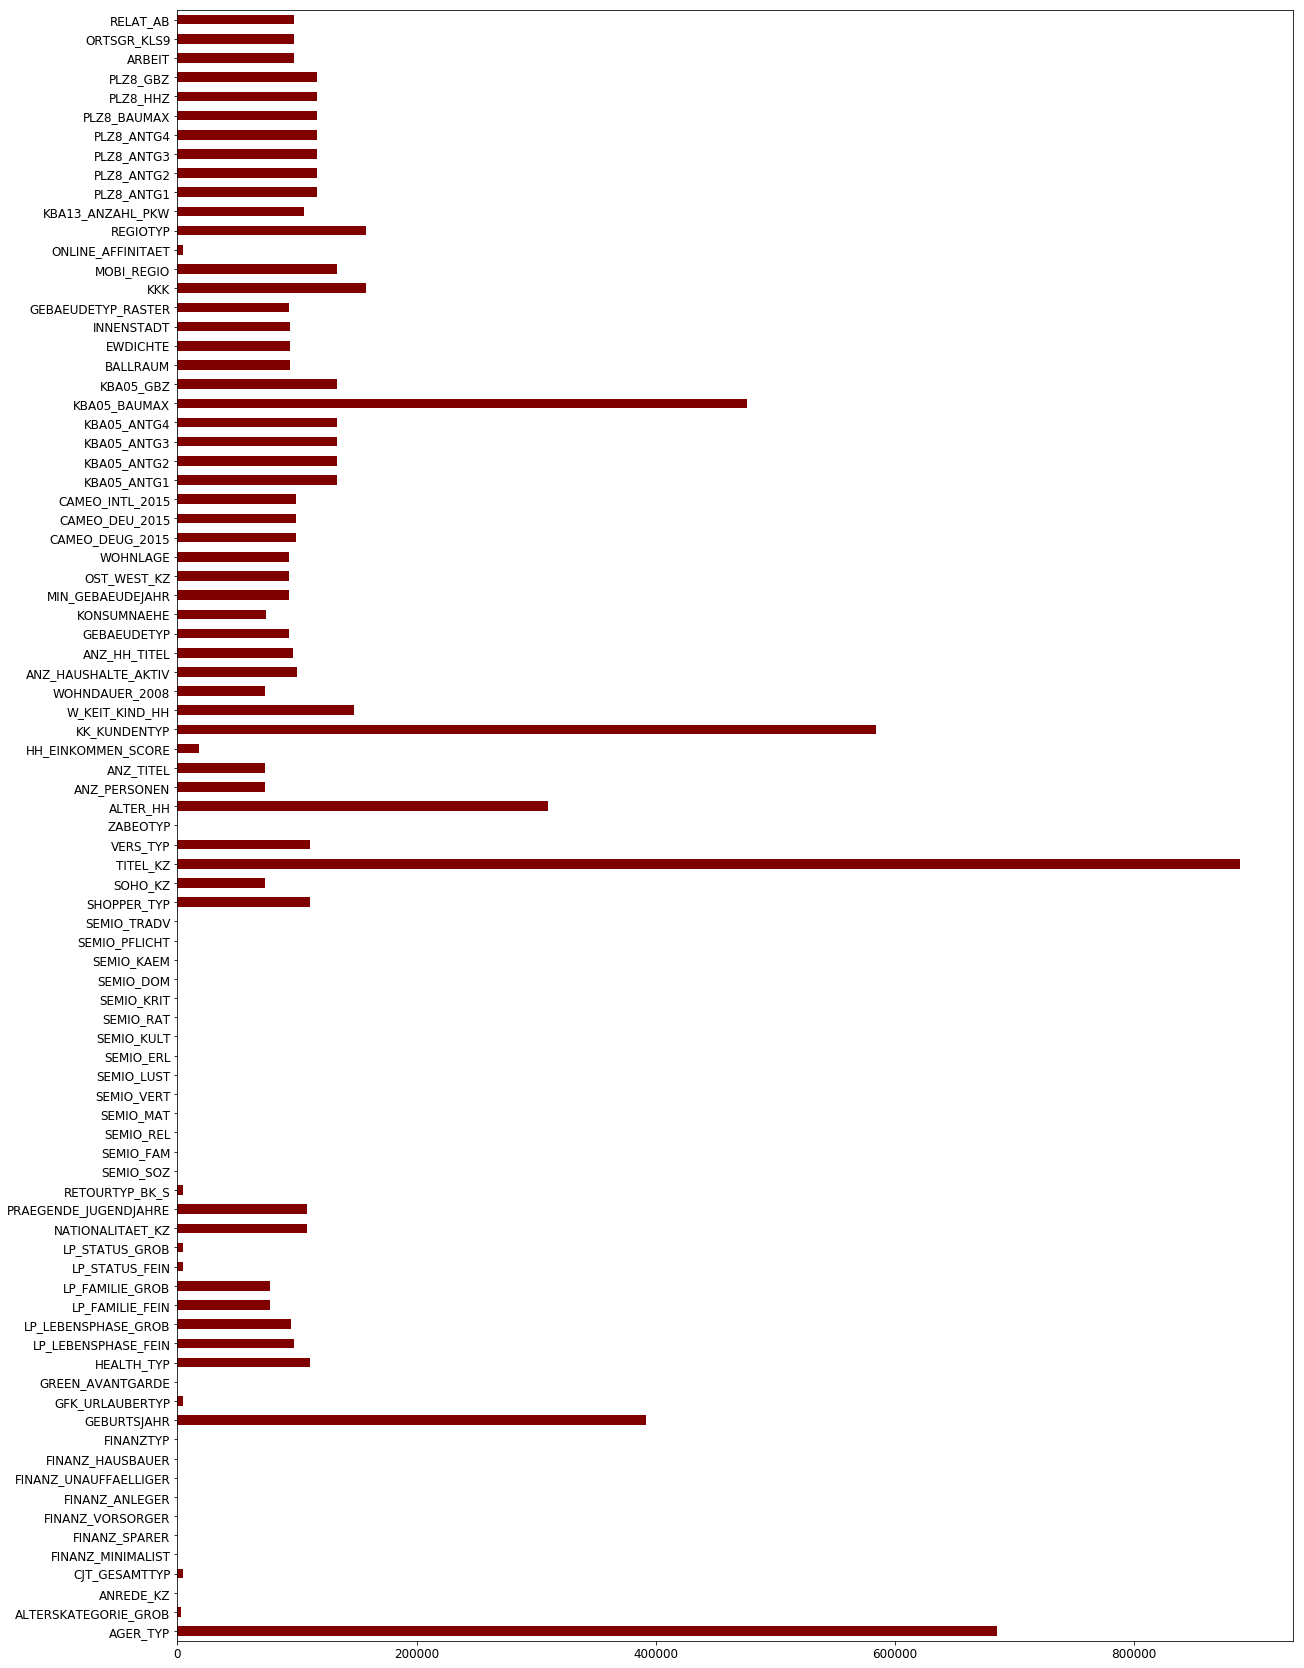

In [17]:
# Visualizing the missing data by columns
azdias_NaN.isnull().sum().plot.barh(figsize=(20,30),fontsize=12,color='maroon')

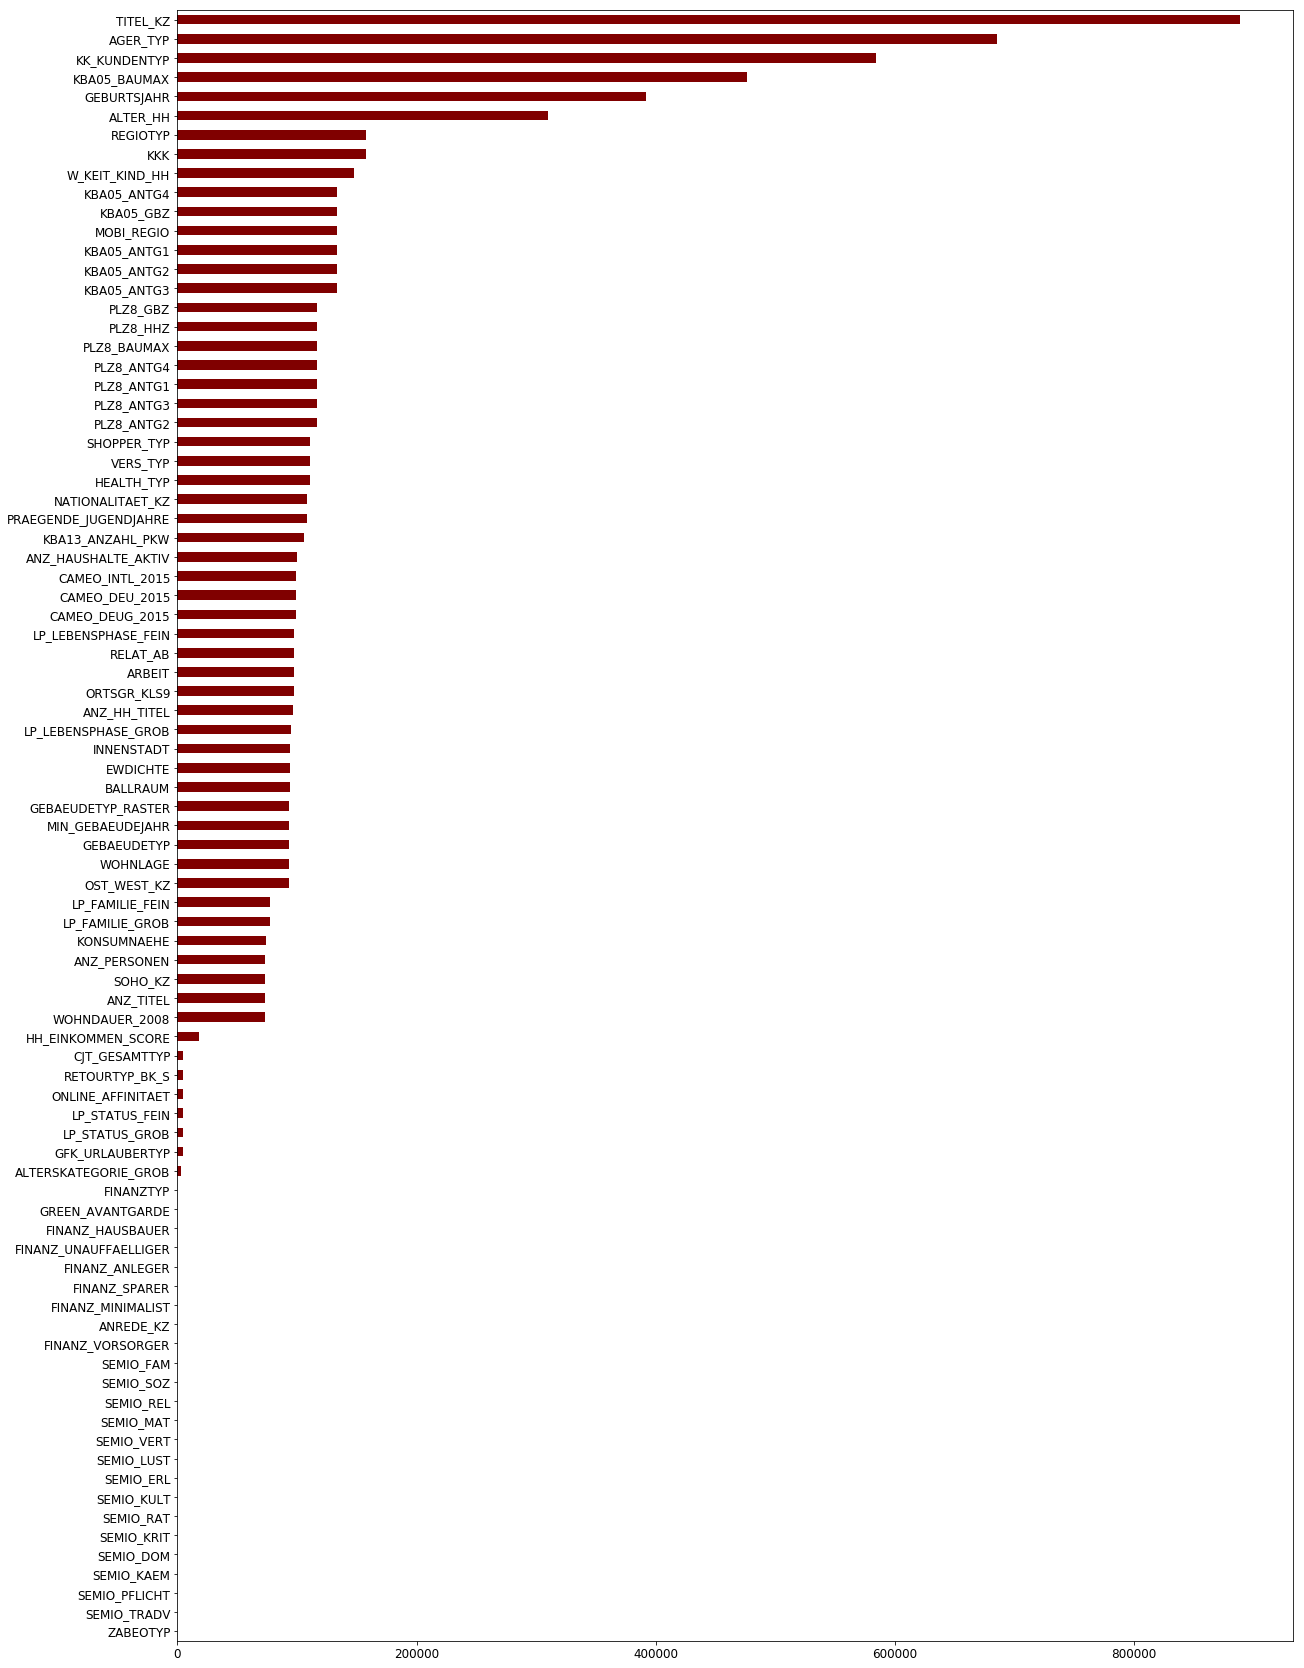

In [18]:
# Visualizing the missing data for each column from highest to lowest.
azdias_NaN.isnull().sum().sort_values().plot.barh(figsize=(20,30),fontsize=12,color='maroon');

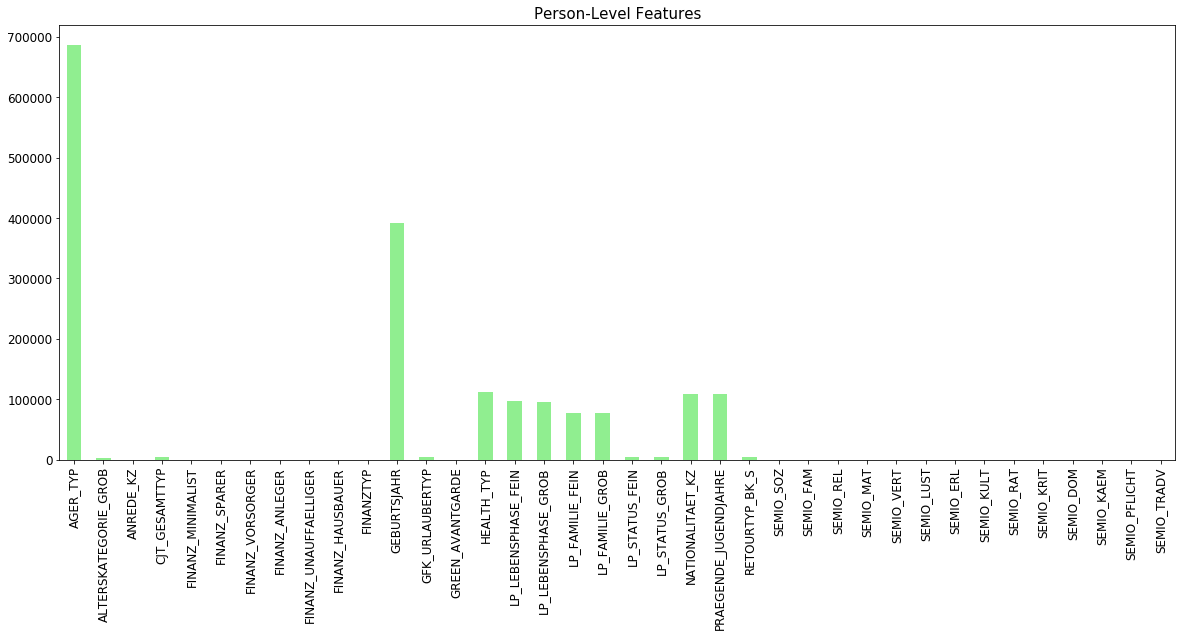

In [19]:
# Visualizing the missing data by each data group namely Person-Level Features here
plt.figure(1,figsize=(20,8))
azdias_NaN.loc[:,'AGER_TYP':'SEMIO_TRADV'].isnull().sum().plot.bar(fontsize=12,color='lightgreen')
plt.title('Person-Level Features',fontsize=15)
plt.show()

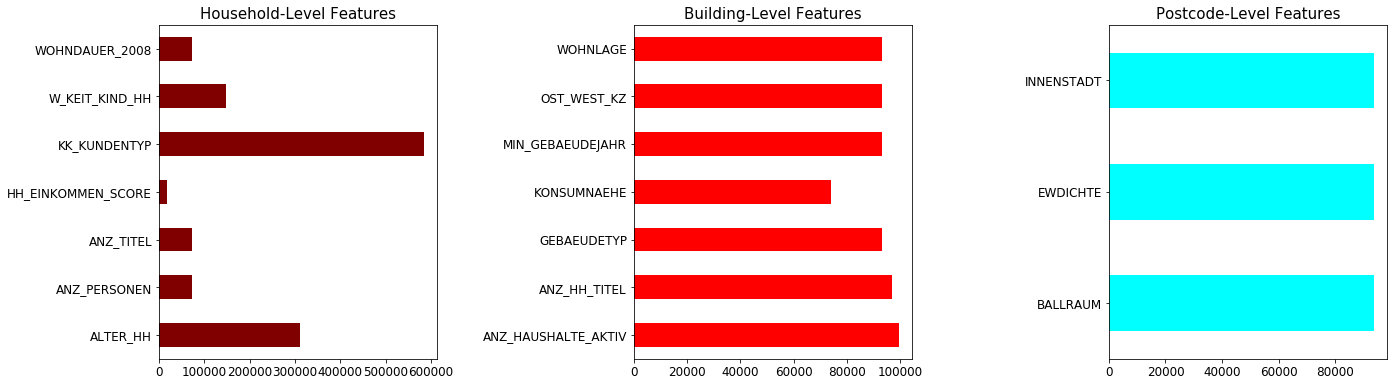

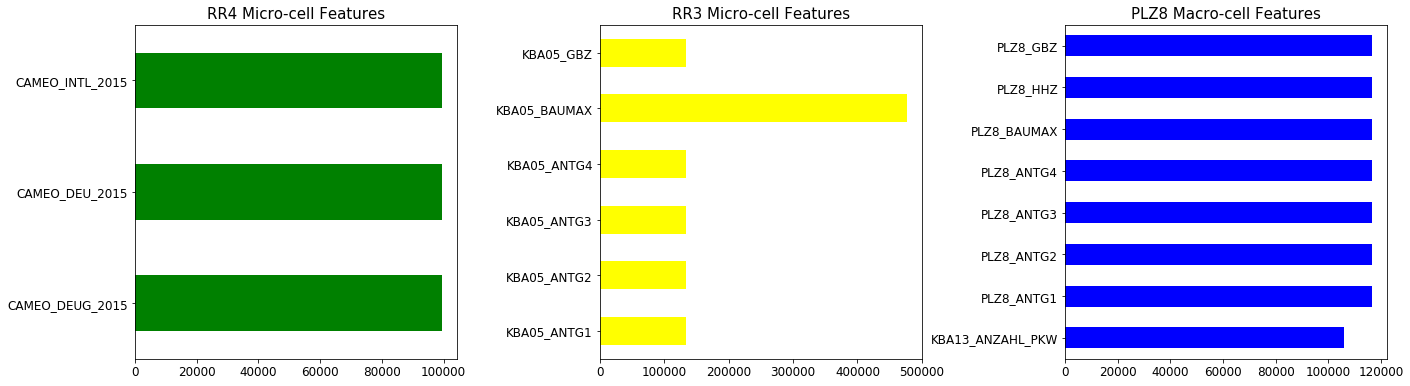

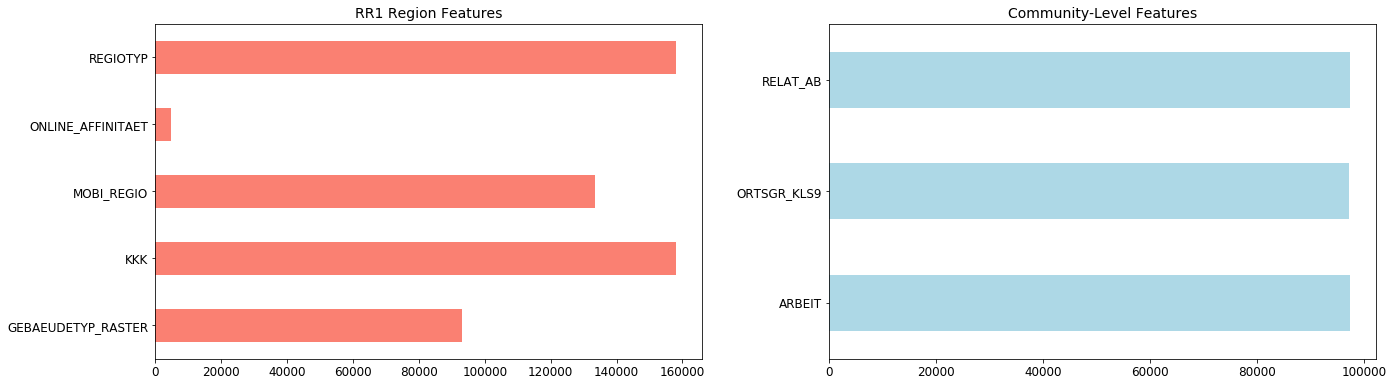

In [20]:
# The remaining Household-Level Features, 
# Building-Level Features, Postcode-Level Features, RR4 Micro-cell Features, RR3 Micro-cell Features, 
# PLZ8 Macro-cell Features, RR1 Region Features, Community-Level Features

plt.figure(2,figsize=(20,6))
plt.subplot(131)
azdias_NaN.loc[:,'ALTER_HH':'WOHNDAUER_2008'].isnull().sum().plot.barh(fontsize=12,color='maroon')
plt.title('Household-Level Features',fontsize=15)

plt.subplot(132)
azdias_NaN.loc[:,'ANZ_HAUSHALTE_AKTIV':'WOHNLAGE'].isnull().sum().plot.barh(fontsize=12,color='red')
plt.title('Building-Level Features',fontsize=15)
plt.tight_layout(pad=3.0)

plt.subplot(133)
azdias_NaN.loc[:,'BALLRAUM':'INNENSTADT'].isnull().sum().plot.barh(fontsize=12,color='aqua')
plt.title('Postcode-Level Features',fontsize=15)

plt.figure(3,figsize=(20,6))
plt.subplot(131)
azdias_NaN.loc[:,'CAMEO_DEUG_2015':'CAMEO_INTL_2015'].isnull().sum().plot.barh(fontsize=12,color='green')
plt.title('RR4 Micro-cell Features',fontsize=15)

plt.subplot(132)
azdias_NaN.loc[:,'KBA05_ANTG1':'KBA05_GBZ'].isnull().sum().plot.barh(fontsize=12,color='yellow')
plt.title('RR3 Micro-cell Features',fontsize=15)
plt.tight_layout(pad=3.0)

plt.subplot(133)
azdias_NaN.loc[:,'KBA13_ANZAHL_PKW':'PLZ8_GBZ'].isnull().sum().plot.barh(fontsize=12,color='blue')
plt.title('PLZ8 Macro-cell Features',fontsize=15)

plt.figure(4,figsize=(20,6))
plt.subplot(121)
azdias_NaN.loc[:,'GEBAEUDETYP_RASTER':'REGIOTYP'].isnull().sum().plot.barh(fontsize=12,color='salmon')
plt.title('RR1 Region Features',fontsize=14)

plt.subplot(122)
azdias_NaN.loc[:,'ARBEIT':'RELAT_AB'].isnull().sum().plot.barh(fontsize=12,color='lightblue')
plt.title('Community-Level Features',fontsize=14)
plt.tight_layout(pad=3.0)

In [21]:
# Calculating the percentage of NaN values in descending order
print('Percentage of NaN values in descending order')
round(azdias_NaN.isnull().sum()/azdias_NaN.shape[0]*100,1).sort_values(ascending=False)

Percentage of NaN values in descending order


TITEL_KZ                 99.8
AGER_TYP                 77.0
KK_KUNDENTYP             65.6
KBA05_BAUMAX             53.5
GEBURTSJAHR              44.0
ALTER_HH                 34.8
REGIOTYP                 17.7
KKK                      17.7
W_KEIT_KIND_HH           16.6
KBA05_ANTG4              15.0
KBA05_GBZ                15.0
MOBI_REGIO               15.0
KBA05_ANTG1              15.0
KBA05_ANTG2              15.0
KBA05_ANTG3              15.0
PLZ8_GBZ                 13.1
PLZ8_HHZ                 13.1
PLZ8_BAUMAX              13.1
PLZ8_ANTG4               13.1
PLZ8_ANTG1               13.1
PLZ8_ANTG3               13.1
PLZ8_ANTG2               13.1
SHOPPER_TYP              12.5
VERS_TYP                 12.5
HEALTH_TYP               12.5
NATIONALITAET_KZ         12.2
PRAEGENDE_JUGENDJAHRE    12.1
KBA13_ANZAHL_PKW         11.9
ANZ_HAUSHALTE_AKTIV      11.2
CAMEO_INTL_2015          11.1
                         ... 
LP_STATUS_FEIN            0.5
CJT_GESAMTTYP             0.5
GFK_URLAUB

In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data engineering tasks such as re-encoding and imputation later.
azdias_NaN = azdias_NaN.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'],axis=1)
azdias_NaN.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [23]:
azdias_NaN.shape

(891221, 79)

In [24]:
azdias_df=azdias_NaN

#### Discussion 1.1.2: Assess Missing Data in Each Column

**Assessment of column wise missing data**

**Overview**

The aim of the data wrangling process is to keep the missing data at bay and create a more robust dataset to remove any outliers which might cause an unintended bias and later affect the clustering process. In the "Udacity_AZDIAS_Subset" dataset, there are 891221 rows and 85 columns in total. 

**Missing data**

Initially the total number of missing values were 4896838 (approximately 6% in the entire dataset). After converting the missing values using the feature summary, the number went up to 8373929 (approximately 11%). After plotting the missing columns , I found the top 6 columns with the maximum number of missing values to have stood out among the rest. These were "TITEL_KZ", "AGER_TYP", "KK_KUDENTYP", "KBA05_BAUMAX", "GEBURTSJAHR" and "ALTER_HH". Each of these 6 columns contribute more than 34% of missing values, leaving the rest of the columns i.e. 79 in total with less than 20% contribution in missing data. Hence, these 6 columns have been identified as the outliers and therefore removed.

1.**AGER_TYP**: Best-ager typology(AGER_TYP has 77 % missing values. This information is partially found in other categories and can be removed without losing significance)

2.**GEBURTSJAHR**: Year of birth(GEBURTSJAHR has 44 % missing values. This variable is also generalized in other person level categories)

3.**TITEL_KZ**: Academic title flag(TITEL_KZ has 99 % missing values. It makes no sense to keep this column and it is easily derived from values such as title holder-household under column LP_STATUS_FIEN)

4.**ALTER_HH**: Birthdate of head of household(ALTER_HH has 35 % missing values. It can also be generalized from other person level categories)

5.**KK_KUNDENTYP**: Consumer pattern over past 12 months (KK_Kundentyp has missing values around 66%)

6.**KBA05_BAUMAX**: Most common building type within the microcell(KBA05_BAUMAX has 53.5 % missing values. It can be derived from other RR3 micro-cell features)

**Remaining missing data in other variables**

Throughout the analysis of missing data, the person-level features was the most balanced with least number of missing observations (excluding the outliers AGER_TYP and GEBURTSJAHR). After grouping the variables feature wise, it was easy to visualize the feature based plots. It was visible that one variable containing missing/unknown values impacted other variables as well in the same feature. For example, PLZ8 macro-cell features has 116515 NaN values for 7 out of 8 of its features. Similarly, RR3 micro-cell features has 5 out of 6 features with same number of missing values. Likewise, RR4 micro-cell features, Postcode Level features and Community Level features have almost equal number missing observations in their individual groups.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [25]:
# How much data is missing in each row of the dataset?
missingdata= azdias_df.isnull().sum(axis=1)
missingdata

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [26]:
# Aggregating missing row data by number of missing values per row
missingdata.value_counts().sort_index()

0     623209
1      15738
2      27926
3      17629
4      12607
5      22515
6      13771
7      13714
8      24592
9       3042
10      5410
11      1127
12       766
13      3255
14      2243
15      4743
16      2505
17       677
18       428
19      1180
20       349
21       150
22       129
23       132
24        69
25        55
26        59
27        24
28         5
29        12
30         6
31         3
32       206
33      2985
34     10816
35      3911
36        84
37       538
38       421
39        77
40       137
41       356
42        21
43     27369
44       155
45       494
47     45578
48         1
49         2
dtype: int64

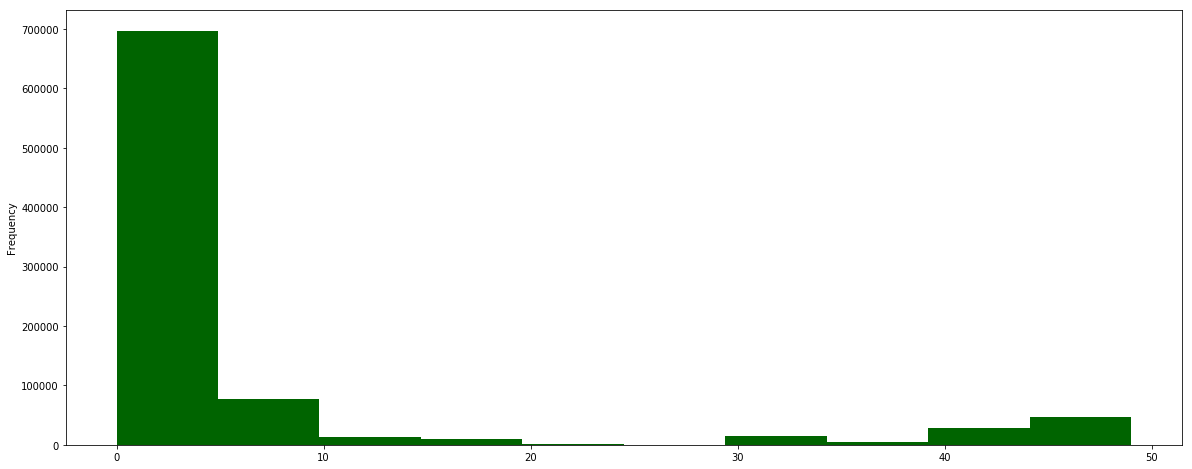

In [27]:
# Visualize counts of number of missing data points by row
missingdata.plot(kind='hist',bins=10,figsize=(20,8),color='darkgreen');

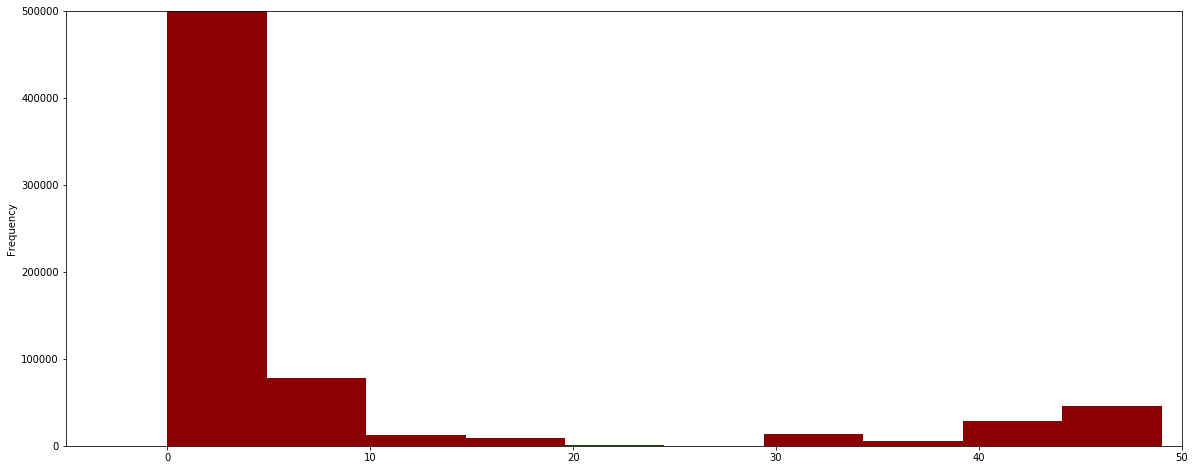

In [28]:
# Zooming in on missing rows from 10 missing data points
missingdata.plot(kind='hist',bins=10,figsize=(20,8),color='darkred',xlim=(-5,50),ylim=(0,500000));

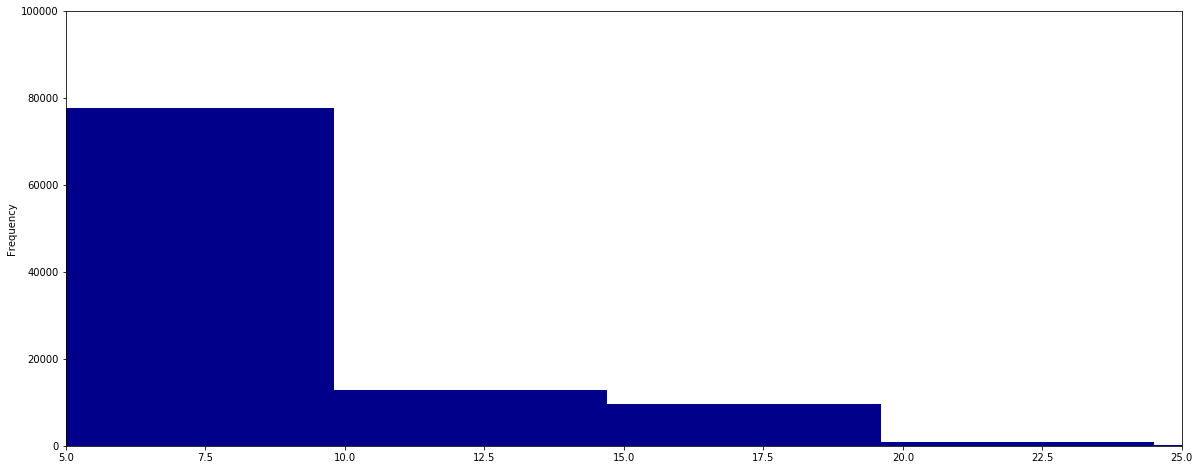

In [29]:
#Zoom in on area from 10 to 25 missing data points
missingdata.plot(kind='hist',bins=10,figsize=(20,8),color='darkblue',xlim=(5,25),ylim=(0,100000));

# Experimenting different thresholds to select a value

In [30]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
#Selecting 10 as the threshold value
data_missing_above10 = azdias_df[azdias_df.index.isin(missingdata[missingdata >= 10].index)]
data_missing_below10 = azdias_df[azdias_df.index.isin(missingdata[missingdata < 10].index)]

print('Rows with data missing above 10 :', data_missing_above10.shape[0], 'or', \
      np.round(data_missing_above10.shape[0]*100/azdias_df.shape[0],2), '% of all data')
print('If above missing rows are removed, then data retained is :', data_missing_below10.shape[0], 'or', \
      np.round(data_missing_below10.shape[0]*100/azdias_df.shape[0],2), '% of all data')

Rows with data missing above 10 : 116478 or 13.07 % of all data
If above missing rows are removed, then data retained is : 774743 or 86.93 % of all data


In [31]:
#Selecting 15 as the threshold value
data_missing_above15 = azdias_df[azdias_df.index.isin(missingdata[missingdata >=15].index)]
data_missing_below15 = azdias_df[azdias_df.index.isin(missingdata[missingdata <15].index)]

print('Rows with data missing above 15 :', data_missing_above15.shape[0], 'or', \
      np.round(data_missing_above15.shape[0]*100/azdias_df.shape[0],2), '% of all data')
print('If above missing rows are removed, then data retained is :', data_missing_below15.shape[0], 'or', \
      np.round(data_missing_below15.shape[0]*100/azdias_df.shape[0],2), '% of all data')

Rows with data missing above 15 : 103677 or 11.63 % of all data
If above missing rows are removed, then data retained is : 787544 or 88.37 % of all data


In [32]:
#Selecting 20 as the threshold value
data_missing_above20 = azdias_df[azdias_df.index.isin(missingdata[missingdata >=20].index)]
data_missing_below20 = azdias_df[azdias_df.index.isin(missingdata[missingdata <20].index)]

print('Rows with data missing above 20 :', data_missing_above20.shape[0], 'or', \
      np.round(data_missing_above20.shape[0]*100/azdias_df.shape[0],2), '% of all data')
print('If above missing rows are removed, then data retained is :', data_missing_below20.shape[0], 'or', \
      np.round(data_missing_below20.shape[0]*100/azdias_df.shape[0],2), '% of all data')

Rows with data missing above 20 : 94144 or 10.56 % of all data
If above missing rows are removed, then data retained is : 797077 or 89.44 % of all data


In [33]:
#Selecting 2 as the threshold value
data_missing_above5 = azdias_df[azdias_df.index.isin(missingdata[missingdata >=5].index)]
data_missing_below5 = azdias_df[azdias_df.index.isin(missingdata[missingdata <5].index)]

print('Rows with data missing above 5 :', data_missing_above5.shape[0], 'or', \
      np.round(data_missing_above5.shape[0]*100/azdias_df.shape[0],2), '% of all data')
print('If above missing rows are removed, then data retained is :', data_missing_below5.shape[0], 'or', \
      np.round(data_missing_below5.shape[0]*100/azdias_df.shape[0],2), '% of all data')

Rows with data missing above 5 : 194112 or 21.78 % of all data
If above missing rows are removed, then data retained is : 697109 or 78.22 % of all data


In [34]:
def comparison_plot(columns):
    '''
    Takes in categorical variables present in both
    dataframes and plots plots a bar of the levels
    in the variable for both data frames.
    
    INPUT: List
    OUTPUT: Figure
    '''
    
    num_rows = len(columns)
    
    fig, ax = plt.subplots(figsize=(20, 25), ncols= 2, nrows= num_rows, squeeze=False)
    
    ax[0][0].set_title("More Missing Values Subset")
    ax[0][1].set_title("Less Missing Values Subset")
    
    for i in range(num_rows):
        sns.countplot(x=columns[i], data= data_missing_above5,ax=ax[i][0])
        sns.countplot(x=columns[i], data= data_missing_below5,ax=ax[i][1])

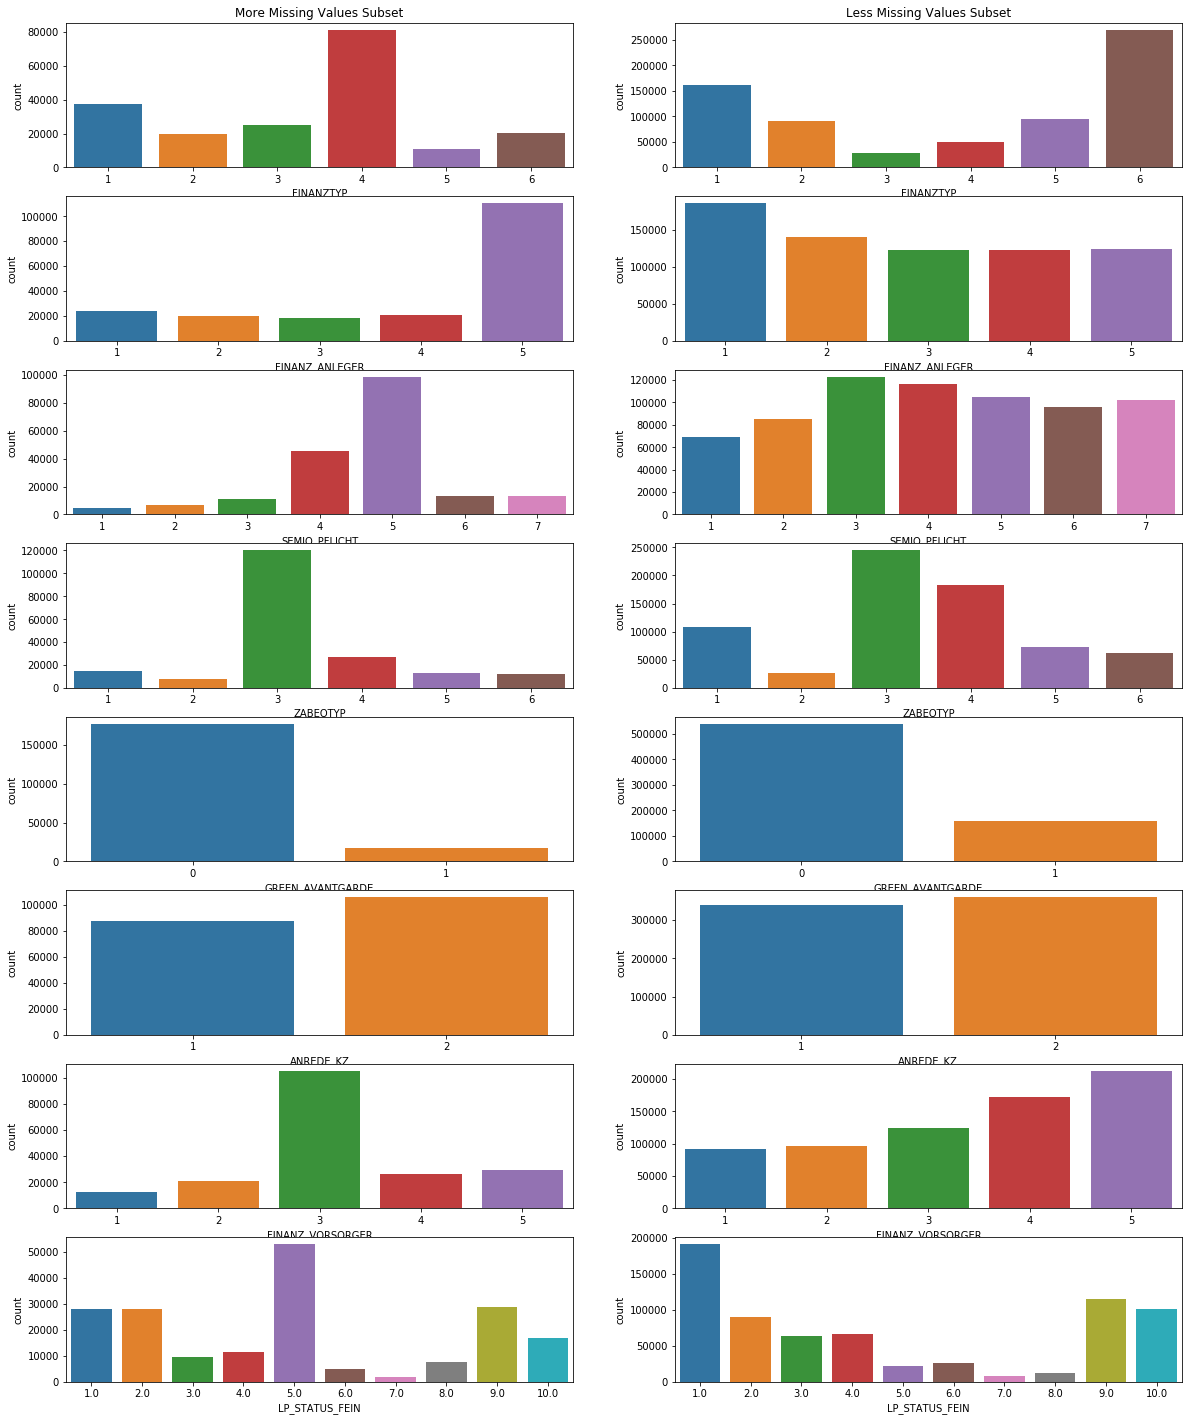

In [35]:
#Manually selecting some columns with zero or very low missing values from the dataframe
comparison_plot(["FINANZTYP", "FINANZ_ANLEGER", "SEMIO_PFLICHT", "ZABEOTYP", "GREEN_AVANTGARDE", "ANREDE_KZ","FINANZ_VORSORGER","LP_STATUS_FEIN"])

In [36]:
data_missing_above5.shape

(194112, 79)

In [37]:
data_missing_below5.shape

(697109, 79)

In [38]:
#Retaining the data below threshold 5 to proceed further
azdias_thres5 = data_missing_below5

In [39]:
azdias_thres5.isnull().sum()

ALTERSKATEGORIE_GROB      1417
ANREDE_KZ                    0
CJT_GESAMTTYP                0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
FINANZTYP                    0
GFK_URLAUBERTYP              0
GREEN_AVANTGARDE             0
HEALTH_TYP               12251
LP_LEBENSPHASE_FEIN          2
LP_LEBENSPHASE_GROB          1
LP_FAMILIE_FEIN              0
LP_FAMILIE_GROB              0
LP_STATUS_FEIN               0
LP_STATUS_GROB               0
NATIONALITAET_KZ         10834
PRAEGENDE_JUGENDJAHRE     6900
RETOURTYP_BK_S               0
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
                         ...  
MIN_GEBAEUDEJAHR             0
OST_WEST

#### Discussion 1.1.3: Assess Missing Data in Each Row


**Assessment of row wise missing data**

**Overview**

The number of missing values per row was calculated. Using the plots, I observed the number of missing values was high during the first 10 rows. However, there was drastic reduction in the number of missing observations after row 5. Further zooming into the values, the break points of the missing observations was found at rows 5, 10, 15, and 20. The fact that K-means requires no missing data to work and our dataset has more ordinal and categorical data than numerical data, if we impute values with mean, mode or median it can impact the truth of the dataset. Hence, imputation of data should be minimized and as much missing data must be removed such that it does not have considerable loss of data.

**Missing data**

Removing the missing data at the threshold 5 would eliminate 21.78 % of the complete data. I am selecting 5 as the threshold because I want to minimize the imputation hence keep its effect at minimum during clustering. Based on this, I compared the distribution of non-missing columns between the two subsets and was able to spot visible differences for both the subsets. In this case, seven different variables were compared. I compared 8 varibales, out of which 5 features showed different distributions. These were: SEMIO_PFLICHT, LP_STATUS_FEIN, FINANZ_VORSORGER, FINANZTYP, FINANZ_ANLEGER. So I would conclude that the discarded rows are qualitatively different to the rows that have been retained.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [40]:
# How many features are there of each data type?
print(feat_info['type'].value_counts())

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64


In [41]:
# Look at the categorical features
feat_info[feat_info['type'] == 'categorical']

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [42]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Removing from feat_info dataframe colums that have already been deleted

feat_info = feat_info[feat_info.attribute != 'TITEL_KZ']
feat_info = feat_info[feat_info.attribute != 'AGER_TYP']
feat_info = feat_info[feat_info.attribute != 'KK_KUNDENTYP']
feat_info = feat_info[feat_info.attribute != 'KBA05_BAUMAX']
feat_info = feat_info[feat_info.attribute != 'GEBURTSJAHR']
feat_info = feat_info[feat_info.attribute != 'ALTER_HH']

In [43]:
# Creating a dataframe with only categorical variables
categorical_variables = azdias_thres5[feat_info[feat_info['type'] == 'categorical']['attribute']]
categorical_variables

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5,8.0,W,8,8A
2,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5,1.0,W,4,4C
4,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4,1.0,W,6,6B
5,2,2.0,2,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4,1.0,W,8,8C
6,2,5.0,4,12.0,0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,4,1.0,W,4,4A
7,1,3.0,5,9.0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1,8.0,W,2,2D
8,1,3.0,6,3.0,1,1.0,1.0,10.0,5.0,1.0,3.0,0.0,2.0,6,3.0,W,1,1A
9,2,4.0,1,12.0,1,1.0,1.0,3.0,2.0,1.0,3.0,0.0,2.0,4,3.0,W,1,1E
10,2,1.0,6,8.0,0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,3,1.0,W,9,9D
18,2,6.0,1,11.0,0,1.0,1.0,8.0,4.0,2.0,1.0,0.0,1.0,4,1.0,W,4,4C


In [44]:
# List for reference of categorical variables
categorical_variables.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 697109 entries, 1 to 891220
Data columns (total 18 columns):
ANREDE_KZ           697109 non-null int64
CJT_GESAMTTYP       697109 non-null float64
FINANZTYP           697109 non-null int64
GFK_URLAUBERTYP     697109 non-null float64
GREEN_AVANTGARDE    697109 non-null int64
LP_FAMILIE_FEIN     697109 non-null float64
LP_FAMILIE_GROB     697109 non-null float64
LP_STATUS_FEIN      697109 non-null float64
LP_STATUS_GROB      697109 non-null float64
NATIONALITAET_KZ    686275 non-null float64
SHOPPER_TYP         684858 non-null float64
SOHO_KZ             697109 non-null float64
VERS_TYP            684858 non-null float64
ZABEOTYP            697109 non-null int64
GEBAEUDETYP         697109 non-null float64
OST_WEST_KZ         697109 non-null object
CAMEO_DEUG_2015     694268 non-null object
CAMEO_DEU_2015      694268 non-null object
dtypes: float64(11), int64(4), object(3)
memory usage: 121.1+ MB


In [45]:
# Separate the categorical variables into binary or multi-variable
binary = []
multivar = []
for x in categorical_variables:
    if len(categorical_variables[x].value_counts()) == 2:
        binary.append(x)
    else:
        multivar.append(x)

In [46]:
# Binary list
binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [47]:
# Multi-variable list
multivar

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [48]:
# Find binary categorical variable non-numeric
azdias_thres5['ANREDE_KZ'].unique()

array([2, 1])

In [49]:
# Finding binary categorical variable non-numeric
azdias_thres5['GREEN_AVANTGARDE'].unique()

array([0, 1])

In [50]:
# Finding binary categorical variable non-numeric
azdias_thres5['SOHO_KZ'].unique()

array([ 1.,  0.])

In [51]:
#Finding binary categorical variable non-numeric
azdias_thres5['VERS_TYP'].unique()

array([  2.,   1.,  nan])

In [52]:
# Finding binary categorical variable non-numeric
azdias_thres5['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

Found the above binary non-numeric variable

In [53]:
azdias_thres5['OST_WEST_KZ'] = azdias_thres5['OST_WEST_KZ']
mapping = {'W': 0, 'O': 1}
azdias_thres5 = azdias_thres5.replace({'OST_WEST_KZ': mapping})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [54]:
# Analysis of column "GEBAEUDETYP"
azdias_thres5['GEBAEUDETYP'].value_counts().sort_index()

1.0    400205
2.0      1855
3.0    156738
4.0       419
5.0         1
6.0       305
8.0    137586
Name: GEBAEUDETYP, dtype: int64

In [55]:
# Dropping multi-variable columns which are not required
cols_to_drop = ['LP_FAMILIE_GROB','LP_STATUS_GROB','GEBAEUDETYP','CAMEO_DEU_2015']
azdias_thres5 = azdias_thres5.drop(cols_to_drop,axis=1)

In [56]:
# Re-encode categorical variable(s) to be kept in the analysis.
multi = []

for x in multivar:
    if x not in cols_to_drop:
        multi.append(x)
        
multi

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_STATUS_FEIN',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'CAMEO_DEUG_2015']

In [57]:
# One Hot Encoding remaining multi-variable categorical variables
azdias_thres5 = pd.get_dummies(azdias_thres5, columns = multi, prefix=multi)

In [58]:
azdias_thres5.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ZABEOTYP_6,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0,0,1,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,1,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,1,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,0,0,1,0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,1,0,0,0,0,0


In [59]:
azdias_thres5.shape

(697109, 133)

In [60]:
azdias_thres5.isna().sum().sum()

146138

#### Discussion 1.2.1: Re-Encode Categorical Features

**Re-encoding Categorical Features**

For the categorical features, I separated categorical variables between binary variables and multiple variables. The 5 binary categorical features, all give information relevant for clustering customer segments so retained them which includes the non-numerical variable.

- The non-numeric binary categorical variable was found to be OST_WEST_KZ. I replaced the non-numeric values with binary values (0 and 1).


- There are 9 multi-level categorical variables out of which relevant variables have been one-hot-encoded and others have been dropped. I analysed  individually these multi-level categories : "CJT_GESAMTTYP", "FINANZTYP", "NATIONALITAET_KZ", "SHOPPER_TYP","ZABEOTYP". These all are related to person-level features and unique by themselves, hence retained them. For "LP_FAMILIE_FEIN","LP_FAMILIE_GROB","LP_STATUS_FEIN", and "LP_STATUS_GROB', I decided to drop 2 of these as they were similar. 


- For "CAMEO_DEUG_2015", and "CAMEO_DEU_2015", both are related to wealth/life stage typology. CAMEO_DEUG_2015 provides rough scale and CAMEO_DEU_2015 provides a detailed scale. I decided to keep the rough scale, since there are lot of values for the detailed scale and it would considerably increase the number of columns. 


- The variable "GFK_URLAUBERTYP" is an analysis of vacation habits with 12 categories. It seemed relevant when I think as a customer who might have different habits and it would be interesting to find out which of them are most subject to a potential target audience.


- After encoding, the current number of variables (columns) are 133.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [61]:
# Identifying features classified as mixed
feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [62]:
# Analyzing "PRAEGENDE_JUGENDJAHRE" and engineering two new variables.
azdias_thres5['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    162871
8.0     126885
5.0      77593
10.0     76403
3.0      48827
15.0     37085
11.0     31244
9.0      31001
6.0      24070
12.0     22362
4.0      19300
1.0      17253
2.0       6624
13.0      4956
7.0       3735
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [63]:
# Engineer a column "AVANTGARDE" 
avantgarde = []

for x in azdias_thres5['PRAEGENDE_JUGENDJAHRE']:
    if x in [1,3,5,8,10,12,14]:
        avantgarde.append(0) # Value 0 denotes 'Mainstream'
    elif x in [2,4,6,7,9,11,13,15]:
        avantgarde.append(1) # Value 1 denotes 'Avantgarde'
    else:
        avantgarde.append(np.nan)

In [64]:
# Add new column "AVANTGARDE" to azdias dataframe
a = pd.Series(avantgarde)
azdias_thres5['AVANTGARDE'] = a.values
azdias_thres5.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,AVANTGARDE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0,1,0,0.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,1,0,0,0,0,0,1.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,1,0,0,0,0.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,0,1,0,0.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,1,0,0,0,0,0,0.0


In [65]:
# Checking engineered feature
azdias_thres5['AVANTGARDE'].value_counts()

0.0    532194
1.0    158015
Name: AVANTGARDE, dtype: int64

In [66]:
# Engineering new column "DECADE" based on decade of birth
azdias_thres5['DECADE'] = azdias_thres5['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6})

In [67]:
# Check engineering
azdias_thres5['DECADE'].value_counts().sort_index()

1.0     23877
2.0     68127
3.0    105398
4.0    157886
5.0    134965
6.0    199956
Name: DECADE, dtype: int64

In [68]:
# Drop original column from dataframe
azdias_thres5 = azdias_thres5.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

In [69]:
#Check df
azdias_thres5[:5]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,AVANTGARDE,DECADE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,1,0,0.0,6.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,1,0,0,0,0,0,1.0,6.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,1,0,0,0,0.0,4.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,1,0,0.0,2.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,1,0,0,0,0,0,0.0,5.0


In [70]:
azdias_thres5['CAMEO_INTL_2015']=azdias_thres5['CAMEO_INTL_2015'].astype(float)

In [71]:
# Investigating "CAMEO_INTL_2015" and engineer two new variables.
azdias_thres5['CAMEO_INTL_2015'].value_counts()

51.0    119315
41.0     81910
24.0     79872
14.0     55376
43.0     50462
54.0     40888
25.0     35343
22.0     28333
45.0     23690
13.0     23021
55.0     20976
23.0     18782
52.0     18309
34.0     16326
15.0     15460
31.0     15042
44.0     13126
12.0     11278
35.0      9189
32.0      9124
33.0      8446
Name: CAMEO_INTL_2015, dtype: int64

In [72]:
azdias_thres5[['CAMEO_INTL_2015']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 697109 entries, 1 to 891220
Data columns (total 1 columns):
CAMEO_INTL_2015    694268 non-null float64
dtypes: float64(1)
memory usage: 10.6 MB


In [73]:
# Engineering a feature based on household wealth
cameo_wealth = []

for x in azdias_thres5['CAMEO_INTL_2015']:
    if 10 < x < 16:
        cameo_wealth.append(5)
    elif 20 < x < 26:
        cameo_wealth.append(4)
    elif 30 < x < 36:
        cameo_wealth.append(3)
    elif 40 < x < 46:
        cameo_wealth.append(2)
    elif 50 < x < 56:
        cameo_wealth.append(1)
    else:
        cameo_wealth.append(np.nan)

In [74]:
# Engineer a feature based on household wealth
cw = pd.Series(cameo_wealth)
azdias_thres5['CAMEO_WEALTH'] = cw.values        

In [75]:
azdias_thres5['CAMEO_WEALTH'].value_counts().sort_index()

1.0    199488
2.0    169188
3.0     58127
4.0    162330
5.0    105135
Name: CAMEO_WEALTH, dtype: int64

In [76]:
# Engineer a feature based on household lifestage
cameo_lifestage = []

for x in azdias_thres5['CAMEO_INTL_2015']:
    if x % 10 == 1:
        cameo_lifestage.append(1)
    elif x % 10 == 2:
        cameo_lifestage.append(2)
    elif x % 10 == 3:
        cameo_lifestage.append(3)
    elif x % 10 == 4:
        cameo_lifestage.append(4)
    elif x % 10 == 5:
        cameo_lifestage.append(5)
    else:
        cameo_lifestage.append(np.nan)

In [77]:
cl = pd.Series(cameo_lifestage)
azdias_thres5['CAMEO_LIFESTAGE'] = cl.values

In [78]:
azdias_thres5['CAMEO_LIFESTAGE'].value_counts().sort_index()

1.0    216267
2.0     67044
3.0    100711
4.0    205588
5.0    104658
Name: CAMEO_LIFESTAGE, dtype: int64

In [79]:
# Remove original column
azdias_thres5 = azdias_thres5.drop(['CAMEO_INTL_2015'],axis=1)

In [80]:
# Verify re-engineering of "CAMEO_INTL_2015
azdias_thres5.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,AVANTGARDE,DECADE,CAMEO_WEALTH,CAMEO_LIFESTAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,0,0.0,6.0,1.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1,0,0,0,0,0,1.0,6.0,4.0,4.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,1,0,0,0,0.0,4.0,2.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,1,0,0.0,2.0,1.0,4.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,1,0,0,0,0,0,0.0,5.0,4.0,2.0


In [81]:
azdias_thres5['WOHNLAGE'].value_counts().sort_index()

0.0        17
1.0     39140
2.0     89382
3.0    222703
4.0    119885
5.0     64074
7.0    153203
8.0      8705
Name: WOHNLAGE, dtype: int64

In [82]:
# Engineer a feature based on rural or not
azdias_thres5['RURAL'] = azdias_thres5['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})

In [83]:
# Engineer a feature based on quality of neighborhood
azdias_thres5['NEIGHBOURHOOD'] = azdias_thres5['WOHNLAGE'].map({0:0,1:1,2:2,3:3,4:4,5:5,7:0,8:0})

In [84]:
# Drop mixed features not required
azdias_thres5 = azdias_thres5.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'],axis=1)

In [85]:
azdias_thres5.shape

(697109, 133)

#### Discussion 1.2.2: Engineer Mixed-Type Features

- I re-engineered the 2 mixed variables "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" into 4 new features namely "AVANTGARDE", "DECADE", "CAMEO_WEALTH" and "CAMEO_LIFESTAGE". 


- Out of the 4, AVANTGARDE was binary re-engineered and DECADE with interval type. For the CAMEO_INTL_2015, this variable has total 55 different categories. I re-engineered it with 5 categories in both CAMEO_WEALTH and CAMEO_LIFESTAGE.


- For other mixed-type features such as 'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB', the information in these features were captured in other features in the dataset such as "LP_FAMILIE_FEIN" and "LP_STATUS_FEIN" and hence dropped them. 


- For the variable KBA05_BAUMAX, it was identified as an outlier with a large number of missing values, and hence was not worth to re-engineer.


- For 'WOHNLAGE', I re-engineered "WOHNLAGE" into 2 featuresone as a binary categorical feature, whether the neighbourhood was rural or not, and the second as a rating scale for the neighborhood. I anticipate that this feature might have an impact on clustering the customer segments.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [86]:
 #Review of features 
azdias_thres5[:1].transpose()

,1
ALTERSKATEGORIE_GROB,1.0
ANREDE_KZ,2.0
FINANZ_MINIMALIST,1.0
FINANZ_SPARER,5.0
FINANZ_VORSORGER,2.0
FINANZ_ANLEGER,5.0
FINANZ_UNAUFFAELLIGER,4.0
FINANZ_HAUSBAUER,5.0
GREEN_AVANTGARDE,0.0
HEALTH_TYP,3.0


In [87]:
# Drop column "MIN_GEBAEUDEJAHR" for irrelevance to customer segments
azdias_thres5 = azdias_thres5.drop('MIN_GEBAEUDEJAHR',axis=1)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [116]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')
    
    for i,V in enumerate(df.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        column_name = V[0]
        missing_unknown = missing_unknown[1:-1].split(',')
        if missing_unknown != ['']:
            hold = []
            for x in missing_unknown:
                if x in ['X','XX']:
                    hold.append(x)
                else:
                    hold.append(int(x))
            df[column_name] = df[column_name].replace(hold,np.nan)
        
    # remove selected columns and rows, ...
    df = df.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'],axis=1)
    missingdata = df.isnull().sum(axis=1)
    df = df[df.index.isin(missingdata[missingdata < 5].index)]
    
    # select, re-encode, and engineer column values.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 0})
    df = df.drop(['LP_FAMILIE_GROB','LP_STATUS_GROB','GEBAEUDETYP','CAMEO_DEU_2015'],axis=1)
    multi = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN',
             'NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','CAMEO_DEUG_2015']
    
    
    df = pd.get_dummies(df, columns = multi, prefix=multi)
    
    avantgarde = []

    for x in df['PRAEGENDE_JUGENDJAHRE']:
        if x in [1,3,5,8,10,12,14]:
            avantgarde.append(0) # Value 0 denotes 'Mainstream'
        elif x in [2,4,6,7,9,11,13,15]:
            avantgarde.append(1) # Value 1 denotes 'Avantgarde'
        else:
            avantgarde.append(np.nan)
    
    a = pd.Series(avantgarde)
    df['AVANTGARDE'] = a.values
    
    df['DEKADE'] = df['PRAEGENDE_JUGENDJAHRE'].map({1:1,
                        2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6})
    
    df = df.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
    
    df['CAMEO_INTL_2015']=df['CAMEO_INTL_2015'].astype(float)
    
    cameo_wealth = []
    for x in df['CAMEO_INTL_2015']:
        
        if 10 < x < 16:
            cameo_wealth.append(5)
        elif 20 < x < 26:
            cameo_wealth.append(4)
        elif 30 < x < 36:
            cameo_wealth.append(3)
        elif 40 < x < 46:
            cameo_wealth.append(2)
        elif 50 < x < 56:
            cameo_wealth.append(1)
        else:
            cameo_wealth.append(np.nan)

    cw = pd.Series(cameo_wealth)
    df['CAMEO_WEALTH'] = cw.values
    
    cameo_lifestage = []
    for x in df['CAMEO_INTL_2015']:
        
        if x % 10 == 1:
            cameo_lifestage.append(1)
        elif x % 10 == 2:
            cameo_lifestage.append(2)
        elif x % 10 == 3:
            cameo_lifestage.append(3)
        elif x % 10 == 4:
            cameo_lifestage.append(4)
        elif x % 10 == 5:
            cameo_lifestage.append(5)
        else:
            cameo_lifestage.append(np.nan)
            
    cl = pd.Series(cameo_lifestage)
    df['CAMEO_LIFESTAGE'] = cl.values
    
    df['RURAL'] = df['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})
    df['NEIGHBOURHOOD'] = df['WOHNLAGE'].map({0:0,1:1,2:2,3:3,4:4,5:5,7:0,8:0})
    
    df = df.drop(['CAMEO_INTL_2015','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX','MIN_GEBAEUDEJAHR'],
                 axis=1)
    
    # Return the new cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [90]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_thres5.isna().sum().sum()

155876

In [91]:
# Checking shape
azdias_thres5.shape

(697109, 132)

In [92]:
# Take a list of column headers
header_list = list(azdias_thres5.columns.values)
header_list

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'OST_WEST_KZ',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 'RELAT_AB',
 'CJT_GESAMTTYP_1.0',
 'CJT_GESAMTT

In [93]:
# Impute nans using mode value
imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
azdias_cleaned = imputer.fit_transform(azdias_thres5)
azdias_cleaned = pd.DataFrame(azdias_cleaned)
azdias_cleaned.head()

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,6.0,1.0,1.0,0.0,4.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,0.0,0.0,1.0,6.0,4.0,4.0,0.0,2.0
2,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,0.0,0.0,0.0,0.0,4.0,2.0,3.0,0.0,3.0
3,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,2.0,1.0,4.0,1.0,0.0
4,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,5.0,4.0,2.0,0.0,5.0


In [94]:
# Applying feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_cleaned = scaler.fit_transform(azdias_cleaned)
azdias_cleaned = pd.DataFrame(azdias_cleaned,columns=header_list)
azdias_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,AVANTGARDE,DECADE,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL,NEIGHBOURHOOD
0,-1.740726,0.969688,-1.522118,1.586768,-1.051497,1.515221,1.047789,1.338667,-0.541398,1.020222,...,-0.395944,-0.331444,2.181087,-0.398283,-0.541398,1.142530,-1.165361,-1.251926,-0.550016,0.972501
1,0.201942,0.969688,-1.522118,0.906946,-1.772674,-0.546081,0.320028,1.338667,1.847069,1.020222,...,-0.395944,-0.331444,-0.458487,-0.398283,1.847069,1.142530,0.877563,0.756098,-0.550016,-0.257306
2,0.201942,-1.031260,0.680524,0.227123,0.390857,-1.233182,0.320028,-0.838345,-0.541398,1.020222,...,2.525607,-0.331444,-0.458487,-0.398283,-0.541398,-0.232084,-0.484386,0.086757,-0.550016,0.357597
3,-1.740726,0.969688,-0.053690,-1.132523,1.112035,-0.546081,-0.407733,1.338667,-0.541398,1.020222,...,-0.395944,-0.331444,2.181087,-0.398283,-0.541398,-1.606699,-1.165361,0.756098,1.818127,-1.487113
4,-0.769392,0.969688,-1.522118,1.586768,-1.772674,1.515221,1.047789,-0.112675,-0.541398,-0.303738,...,-0.395944,-0.331444,-0.458487,-0.398283,-0.541398,0.455223,0.877563,-0.582585,-0.550016,1.587404


In [95]:
# Making a copy ready for Principal Component Analysis
azdias_pca = azdias_cleaned.copy()
azdias_pca.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,AVANTGARDE,DECADE,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL,NEIGHBOURHOOD
0,-1.740726,0.969688,-1.522118,1.586768,-1.051497,1.515221,1.047789,1.338667,-0.541398,1.020222,...,-0.395944,-0.331444,2.181087,-0.398283,-0.541398,1.142530,-1.165361,-1.251926,-0.550016,0.972501
1,0.201942,0.969688,-1.522118,0.906946,-1.772674,-0.546081,0.320028,1.338667,1.847069,1.020222,...,-0.395944,-0.331444,-0.458487,-0.398283,1.847069,1.142530,0.877563,0.756098,-0.550016,-0.257306
2,0.201942,-1.031260,0.680524,0.227123,0.390857,-1.233182,0.320028,-0.838345,-0.541398,1.020222,...,2.525607,-0.331444,-0.458487,-0.398283,-0.541398,-0.232084,-0.484386,0.086757,-0.550016,0.357597
3,-1.740726,0.969688,-0.053690,-1.132523,1.112035,-0.546081,-0.407733,1.338667,-0.541398,1.020222,...,-0.395944,-0.331444,2.181087,-0.398283,-0.541398,-1.606699,-1.165361,0.756098,1.818127,-1.487113
4,-0.769392,0.969688,-1.522118,1.586768,-1.772674,1.515221,1.047789,-0.112675,-0.541398,-0.303738,...,-0.395944,-0.331444,-0.458487,-0.398283,-0.541398,0.455223,0.877563,-0.582585,-0.550016,1.587404


### Discussion 2.1: Apply Feature Scaling

**FEATURE SCALING**

- I tried to minimize imputation by eliminating most of the missing data to prevent from ruining the truthfulness of the dataset. 


- When it boils down to finally applying the imputations on the less number of missing values, I chose to fill those values with the most frequent value. It makes sense to me because replacing those values with mean or median might pull the dataset to the center, hence not accounting for the prominence of categorical and ordinal data as discussed in section 1.1.3. Moreover, using most frequent values would select highest values for the features which would probably be visible during clustering.


- Next, for the feature scaling, I selected StandardScaler which scales each feature to mean 0 and standard deviation. I performed imputation then followed with scaling to achieve maximum accuracy in the modelling stage. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [96]:
# Applying PCA to the data.
def do_pca(n_components,data):
    '''
    Transforms data using PCA to create n_components and provides back the results of the transformation
    INPUT:  n_components - int - the number of principal components to create
            data - the data you would like to transform
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    #X = StandardScaler().fit_transform(data)
    X = data
    pca = PCA(n_components,whiten=True,random_state=42)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [97]:
pca, azdias_pca = do_pca(132,azdias_pca)

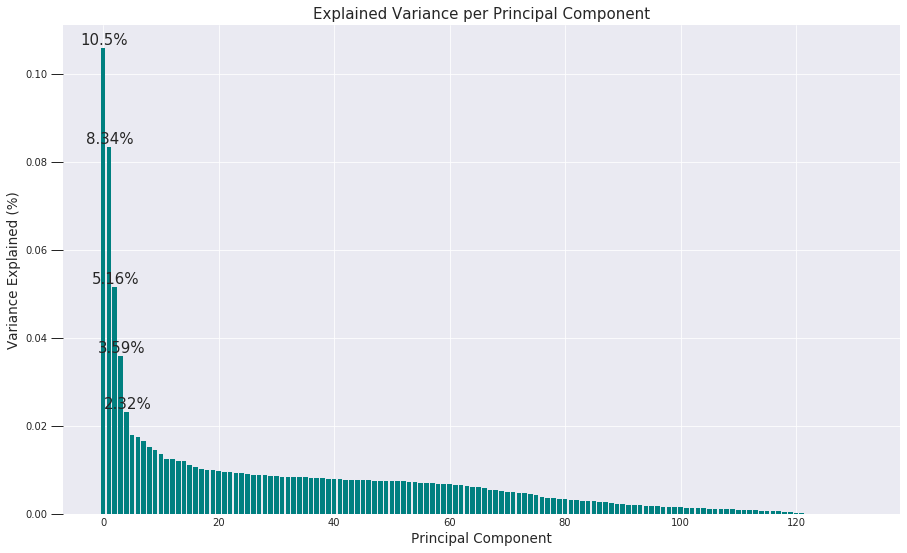

In [98]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components
    INPUT: pca - the result of instantian of PCA in scikit learn
    OUTPUT: none
    '''
    sns.set_style("darkgrid")
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(15,9))
    ax = plt.subplot(111)
    plt.style.use("ggplot")
    
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals,color='teal')
    for i in range(0,ind[5]):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2,vals[i]), va='bottom',ha='center',fontsize=15)
        
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=1,length=12)
    
    ax.set_xlabel("Principal Component",fontsize=13.5)
    ax.set_ylabel("Variance Explained (%)",fontsize=13.5)
    plt.title("Explained Variance per Principal Component",fontsize=15)
    
    plt.show()
    
    
scree_plot(pca)


[ 0.10576708  0.18920089  0.24088761  0.27685662  0.30010121  0.3181664
  0.3357849   0.35237663  0.36762471  0.38228959  0.39599676  0.4086205
  0.42107078  0.43316002  0.4451849   0.45637143  0.46713626  0.47750699
  0.48765677  0.49763714  0.50735748  0.51700288  0.5265259   0.53597418
  0.54524588  0.55435673  0.56334262  0.5722741   0.58111359  0.58990116
  0.59864502  0.60722201  0.61569605  0.62416226  0.6325637   0.6409251
  0.64924906  0.65742615  0.66558459  0.67363292  0.68166686  0.6896125
  0.6975093   0.70534187  0.71315506  0.72091807  0.72863081  0.73629223
  0.74393729  0.75156674  0.75914186  0.76665639  0.77411036  0.78150878
  0.78876761  0.79596985  0.80308464  0.81009546  0.81704134  0.82396282
  0.83082062  0.83753774  0.84418991  0.85064677  0.8568181   0.8629102
  0.86878023  0.87439822  0.87983883  0.88514326  0.89029849  0.8952909
  0.90020429  0.90500633  0.9095713   0.91395556  0.91779939  0.92158615
  0.9252428   0.92871149  0.93214151  0.9354213   0.93864

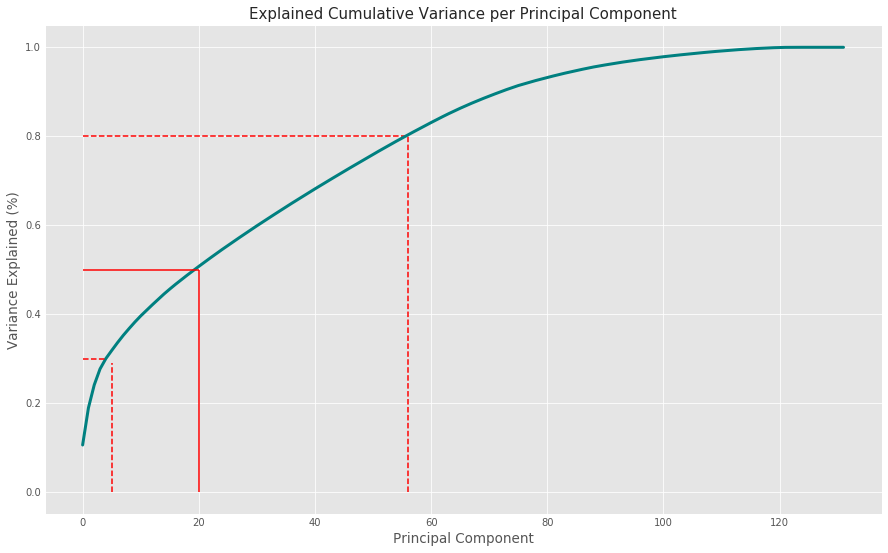

In [99]:
def scree_plot2(pca):
    '''
    Creates a scree plot associated with the principal components
    INPUT: pca - the result of instantian of PCA in scikit learn
    OUTPUT: none
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(15,9))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    
    ax.plot(ind, cumvals,color='teal',linewidth=3)
    plt.hlines(y=0.8, xmin=0, xmax=56, color='red', linestyles='dashed',zorder=1)
    plt.vlines(x=56, ymin=0, ymax=0.8, color='red', linestyles='dashed',zorder=2)
    plt.hlines(y=0.3, xmin=0, xmax=4, color='red', linestyles='dashed',zorder=3)
    plt.vlines(x=5, ymin=0, ymax=0.29, color='red', linestyles='dashed',zorder=4)
    plt.hlines(y=0.5, xmin=0, xmax=20, color='red', linestyles='-',zorder=5)
    plt.vlines(x=20, ymin=0, ymax=0.5, color='red', linestyles='-',zorder=6)
    
    ax.set_xlabel("Principal Component",fontsize=13.5)
    ax.set_ylabel("Variance Explained (%)",fontsize=13.5)
    plt.title("Explained Cumulative Variance per Principal Component",fontsize=15)
    
    print(cumvals)
    
scree_plot2(pca)

In [100]:
# Calculating cumulative percentage of variance captured by 21 principal components
pca1 = pca.explained_variance_ratio_.tolist()
print('Explained variability by all 21 components',np.sum(pca1[:21]))

Explained variability by all 21 components 0.507357478533


In [425]:
# Calculating cumulative percentage of variance captured by 21 principal components
pca2 = pca.explained_variance_ratio_.tolist()
print('Explained variability by all 5 components',np.sum(pca2[:5]))

Explained variability by all 5 components 0.300101207463


Going with number of components that explain 50% variability in data

In [101]:
# Re-apply PCA to the data while selecting for number of components to retrain.
pca_2, azdias_cleaned = do_pca(21,azdias_cleaned)

### Discussion 2.2: Perform Dimensionality Reduction

After performing principal component analysis (PCA) on the data, I plotted the explained variance against the number of principal components. Then, I also determined the explained cumulative variance for each principal components.The results demonstrated as follows:

- The 58 principal components explained 80 percent variability in the data
- Likewise, 21 principal components explained 50 percent variability in the data
- And finally 5 components explained 30 percent variability in the data

The choice to select the number of principal components was tricky. However, it was clear that little variance retained as the number of principal compenents increased. If I select 58 components which explain variance of 80% over 21 components with 50% variability, it is visible that the additional 37 components only account for 30% of the variablity in the data. This explains the diminishing returns if we would consider these extra components. Similarly, for the 5 principal components explaining 30% variability meant I was losing around 70% information at this point and this might over simplify resulting in inaccurate predictions. Hence, I chose 21 components as a safe bet which seems to capture half of the variability in the data and proceeded further.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [102]:
pca_2.components_

array([[ -1.17437631e-01,   6.97352164e-03,  -2.03631368e-01, ...,
         -1.12922641e-01,  -1.26718897e-01,   1.46556589e-01],
       [  2.22540687e-01,   4.74755985e-02,   6.11808565e-02, ...,
         -8.78614713e-03,  -7.26357637e-02,   6.85716943e-02],
       [  2.78714903e-02,  -3.48797538e-01,   1.35464175e-01, ...,
         -1.11053964e-02,  -4.79267081e-02,   3.97719035e-02],
       ..., 
       [ -3.77232252e-02,   1.41289208e-02,   1.41787809e-02, ...,
          5.56678573e-02,  -1.12388975e-01,   7.87685579e-02],
       [ -3.64255582e-02,   3.55688721e-02,  -4.27374222e-05, ...,
         -7.42496249e-02,   1.80635822e-02,  -4.20060099e-03],
       [ -1.83026247e-03,   1.20934809e-02,  -1.50656328e-02, ...,
         -5.59137300e-02,  -2.73533560e-02,   3.90389457e-02]])

In [103]:
# Quick look at the value of variance explained by each component
pca_2.explained_variance_ratio_

array([ 0.10576708,  0.08343381,  0.05168672,  0.03596883,  0.02324332,
        0.01804534,  0.01760239,  0.01656173,  0.01522297,  0.01460932,
        0.01361623,  0.01251734,  0.01231223,  0.01188134,  0.01177986,
        0.01080281,  0.01043893,  0.00985246,  0.00950248,  0.00939791,
        0.00931628])

In [104]:
# Create a dataframe of Explained Variance
dimensions = ['PC {}'.format(i) for i in range(1,len(pca_2.components_)+1)]
ratio = pd.DataFrame(pca_2.explained_variance_ratio_,columns = ['EXPLAINED VARIANCE'])
ratio = ratio.round(4)
ratio.index = dimensions
ratio

,EXPLAINED VARIANCE
PC 1,0.1058
PC 2,0.0834
PC 3,0.0517
PC 4,0.0360
PC 5,0.0232
PC 6,0.0180
PC 7,0.0176
PC 8,0.0166
PC 9,0.0152
PC 10,0.0146


In [106]:
# Create a dataframe with the weights for each principal component
weights = pd.DataFrame(pca_2.components_, columns=header_list)
weights = weights.round(4)
weights.index = dimensions
weights[:5]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,AVANTGARDE,DECADE,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL,NEIGHBOURHOOD
PC 1,-0.1174,0.0070,-0.2036,0.1414,-0.1110,0.0708,0.0791,0.1381,-0.1018,0.0315,...,0.0008,0.0336,0.0908,0.1139,-0.1018,0.1057,-0.1827,-0.1129,-0.1267,0.1466
PC 2,0.2225,0.0475,0.0612,-0.2124,0.2067,-0.1979,-0.2068,0.1046,-0.0201,-0.0466,...,0.0122,0.0143,0.0495,0.0337,-0.0201,-0.2197,-0.0807,-0.0088,-0.0726,0.0686
PC 3,0.0279,-0.3488,0.1355,-0.0600,0.0554,-0.1578,-0.0476,-0.0643,0.0702,-0.0046,...,-0.0050,-0.0013,0.0099,0.0192,0.0702,-0.0597,-0.0148,-0.0111,-0.0479,0.0398
PC 4,-0.0305,0.0802,0.0299,0.0054,-0.0154,-0.0820,0.0821,-0.0699,0.3220,-0.0042,...,-0.0306,-0.0210,-0.0292,-0.0296,0.3220,0.0331,0.0985,0.0496,-0.2224,0.1266
PC 5,0.0445,-0.0224,0.0791,-0.0132,-0.0032,0.0618,-0.1146,-0.0948,-0.0772,0.0405,...,-0.0107,-0.0111,0.0419,0.0627,-0.0772,0.0124,-0.0781,-0.0460,-0.0236,0.0747


In [107]:
result = pd.concat([ratio, weights], axis = 1, sort=False, join_axes=[ratio.index])
result[:3]

,EXPLAINED VARIANCE,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,AVANTGARDE,DECADE,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL,NEIGHBOURHOOD
PC 1,0.1058,-0.1174,0.0070,-0.2036,0.1414,-0.1110,0.0708,0.0791,0.1381,-0.1018,...,0.0008,0.0336,0.0908,0.1139,-0.1018,0.1057,-0.1827,-0.1129,-0.1267,0.1466
PC 2,0.0834,0.2225,0.0475,0.0612,-0.2124,0.2067,-0.1979,-0.2068,0.1046,-0.0201,...,0.0122,0.0143,0.0495,0.0337,-0.0201,-0.2197,-0.0807,-0.0088,-0.0726,0.0686
PC 3,0.0517,0.0279,-0.3488,0.1355,-0.0600,0.0554,-0.1578,-0.0476,-0.0643,0.0702,...,-0.0050,-0.0013,0.0099,0.0192,0.0702,-0.0597,-0.0148,-0.0111,-0.0479,0.0398


In [108]:
# for comp in range(58, azdias_3.shape[1]):
#     if result['EXPLAINED VARIANCE'].sum() > 0.86:
#         break
        
num_comps = result.shape[0]
print("The {} components, explains {}% of the variability in the original data.".format(result.shape[0],result['EXPLAINED VARIANCE'].sum()*100))

The 21 components, explains 50.350000000000016% of the variability in the original data.


In [109]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def show_pca_weights(principal_component,no_of_weights):
    
    dimensions = ['PC {}'.format(i) for i in range(1,len(pca_2.components_)+1)]
    
    ratio = pd.DataFrame(pca_2.explained_variance_ratio_,columns = ['EXPLAINED VARIANCE'])
    ratio = ratio.round(4)
    ratio.index = dimensions
    
    weights = pd.DataFrame(pca_2.components_, columns=header_list)
    weights = weights.round(4)
    weights.index = dimensions
    
    result = pd.concat([ratio, weights], axis = 1, sort=False, join_axes=[ratio.index])
    result[:5]
    print("Principal Component", (principal_component))
    print('-' * 30)
    print(result.iloc[(principal_component)-1].sort_values(ascending=False)[:no_of_weights])
    print('-' * 30)
    print(result.iloc[(principal_component)-1].sort_values()[:no_of_weights])

In [110]:
#Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
show_pca_weights(1,10)

Principal Component 1
------------------------------
PLZ8_ANTG3            0.1895
HH_EINKOMMEN_SCORE    0.1833
PLZ8_ANTG4            0.1828
ORTSGR_KLS9           0.1677
EWDICHTE              0.1641
NEIGHBOURHOOD         0.1466
FINANZ_SPARER         0.1414
FINANZ_HAUSBAUER      0.1381
PLZ8_ANTG2            0.1293
KBA05_ANTG4           0.1286
Name: PC 1, dtype: float64
------------------------------
MOBI_REGIO          -0.2092
FINANZ_MINIMALIST   -0.2036
KBA05_ANTG1         -0.1953
PLZ8_ANTG1          -0.1888
KBA05_GBZ           -0.1861
CAMEO_WEALTH        -0.1827
KONSUMNAEHE         -0.1393
PLZ8_GBZ            -0.1379
INNENSTADT          -0.1358
RURAL               -0.1267
Name: PC 1, dtype: float64


In [111]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
show_pca_weights(2,10)

Principal Component 2
------------------------------
ALTERSKATEGORIE_GROB    0.2225
FINANZ_VORSORGER        0.2067
ZABEOTYP_3              0.1990
SEMIO_ERL               0.1813
RETOURTYP_BK_S          0.1584
SEMIO_LUST              0.1563
W_KEIT_KIND_HH          0.1194
LP_STATUS_FEIN_1.0      0.1140
FINANZ_HAUSBAUER        0.1046
CJT_GESAMTTYP_2.0       0.0985
Name: PC 2, dtype: float64
------------------------------
DECADE                  -0.2197
FINANZ_SPARER           -0.2124
SEMIO_REL               -0.2117
FINANZ_UNAUFFAELLIGER   -0.2068
SEMIO_TRADV             -0.2024
SEMIO_PFLICHT           -0.1990
FINANZ_ANLEGER          -0.1979
SEMIO_KULT              -0.1663
ONLINE_AFFINITAET       -0.1633
SEMIO_RAT               -0.1575
Name: PC 2, dtype: float64


In [112]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
show_pca_weights(3,10)

Principal Component 3
------------------------------
SEMIO_VERT           0.3249
SEMIO_FAM            0.2597
SEMIO_SOZ            0.2579
SEMIO_KULT           0.2467
FINANZTYP_5          0.1383
FINANZ_MINIMALIST    0.1355
SHOPPER_TYP_0.0      0.1272
SEMIO_REL            0.1161
ZABEOTYP_1           0.1146
RETOURTYP_BK_S       0.0880
Name: PC 3, dtype: float64
------------------------------
ANREDE_KZ            -0.3488
SEMIO_KAEM           -0.3188
SEMIO_DOM            -0.2860
SEMIO_KRIT           -0.2639
SEMIO_ERL            -0.2001
SEMIO_RAT            -0.1626
FINANZ_ANLEGER       -0.1578
FINANZTYP_1          -0.1035
SHOPPER_TYP_2.0      -0.1022
LP_STATUS_FEIN_2.0   -0.0862
Name: PC 3, dtype: float64


### Discussion 2.3: Interpret Principal Components

**First principal component**

It represents a combination of features that relate to population density in an area and the household income of that area. Positive correlations with increasing population density and wealth and negative correlations with low density, movement patterns and low financial interest features.

**The top 5 positive weights**

- PLZ8_ANTG3 - the number of 6-10 family homes in the PLZ8 region
- HH_EINKOMMEN_SCORE - Estimated household net income
- PLZ8_ANTG4- the number of 10+ family houses in the PLZ8 region
- ORTSGR_KLS9- the size of the community
- EWDICHTE- density of household per kilometer square

**The top 5 negative weights**

- MOBI_REGIO - movement patters
- FINANZ_MINIMALIST - Low financial interests
- KBA05_ANTG1- the number of 1-2 family houses in the microcell
- PLZ8_ANTG1- the number of 1-2 family houses in PLZ8 region
- KBA05_GBZ- the number of buildings in the microcell.

**Second principal component**

It represents the combination of features related to older people with conservative traditional values. Positive weights are related to personality and financial traits such as age, financial prudence and energy consumption. The negative weights align contrary and more towards people who are religious, a money saver and traditional minded.

**The top 5 positive weights**

- ALTERSKATEGORIE_GROB - Estimated age on given name analysis 
- FINANZ_VORSORGER- Financial typology- prepared
- ZABEOTYP_3- the energy consumption typology
- SEMIO_ERL- Personality typology oriented
- RETOURTYP_BK_S - the return shopper type

**The top 5 negative weights**

- DECADE- The age of youth
- FINANZ_SPARER- Financial typology is money-saver
- SEMIO_REL- Personality typology is religious
- FINANZ_UNAUFFAELLIGER- Financial typology is not attractive
- SEMIO_TRADV - Personality typology is traditional-minded.

**Third principal component**

It represents the combination of features related to individuals primarily based on their gender and personality type. The positive weights signify individuals who are into investing but from different cultural and social personality traits. The negative weights relate similarly but more inclined towards gender with more hyperactive personality types such as those who are dominant and critics.


**The top 5 positive weights**

- SEMIO_VERT- the personality type is dreamful
- SEMIO_FAM- the personality type is family-minded
- SEMIO_SOZ - the personality type is social
- SEMIO_KULT- the personality type is cultural
- FINANZTYP_5- financial type -investor

**The top 5 negative weights**

- ANREDE_KZ- Gender
- SEMIO_KAEM- the personality typology is combative attitude
- SEMIO_DOM- the personality typology is dominant
- SEMIO_KRIT- the personality typology is critical minded
- SEMIO_ERL - the personality typology is event oriented

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

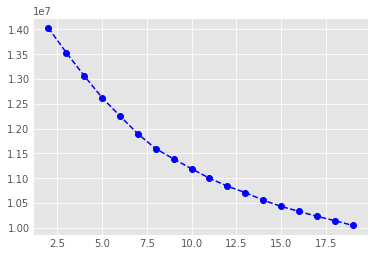

In [115]:
# Over a number of different cluster counts...
df = pd.DataFrame()
for k in range(2,20):

    # run k-means clustering on the data and...
    model = KMeans(n_clusters=k)
    model.fit(azdias_cleaned)
    
    # compute the average within-cluster distances.
    df = pd.concat([df,pd.DataFrame([[k,np.abs(model.score(azdias_cleaned))]])])

plt.plot(df[0], df[1], linestyle='--', marker='o', color='b')

In [121]:
df=df.rename(columns={0:'Number of Clusters',1:'Average within cluster distances'})
df

,Number of Clusters,Average within cluster distances
Number of Clusters,2,1.403354e+07
Number of Clusters,3,1.353304e+07
Number of Clusters,4,1.306747e+07
Number of Clusters,5,1.262480e+07
Number of Clusters,6,1.225537e+07
Number of Clusters,7,1.189478e+07
Number of Clusters,8,1.159478e+07
Number of Clusters,9,1.138872e+07
Number of Clusters,10,1.118987e+07
Number of Clusters,11,1.099933e+07


In [122]:
pca_2

PCA(copy=True, iterated_power='auto', n_components=21, random_state=42,
  svd_solver='auto', tol=0.0, whiten=True)

In [123]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_10 = KMeans(n_clusters=10, n_init=10, max_iter=300, random_state=42)
population_clusters = kmeans_10.fit_predict(azdias_cleaned)

### Discussion 3.1: Apply Clustering to General Population

**Number of clusters**


I used sklearn's KMeans class to perform k-means clustering on the PCA-transformed data. Then, calculated the average within cluster distances for a number of clusters ranging from 2 to 20. As expected, the distance decreased as the number of clusters increased. There wasn't a clear picture of the elbow point, however there was clear shift in the rate of diminishing values from clusters 8 to 12. The rate of change in average within cluster distances till cluster 10 was around 0.29 (1.40-1.11), post that the rate of change reduced significantly to 0.11. Somewhere between cluster 8 to 12, the curve started to flatten. And from the calculations, 10 clusters seem to represent the shift in change clearly. Hence, I chose the number of clusters 10 (between 8 and 12) and proceeded ahead.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [124]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [125]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [126]:
customers.shape

(191652, 85)

In [127]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Apply population data wrangling to customer dataframe
customers_clean = clean_data(customers)

In [128]:
customers_clean.shape

(125178, 132)

In [129]:
# Checking for null values
customers_clean.isnull().any().sum()

21

In [130]:
customers_clean = imputer.transform(customers_clean)
customers_clean = pd.DataFrame(customers_clean)
customers_clean.head()

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,2.0,5.0,3.0,1.0,0.0
1,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,0.0,0.0,0.0,0.0,1.0,2.0,3.0,4.0,0.0,2.0
2,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,0.0,1.0,0.0,0.0,0.0,4.0,2.0,1.0,0.0,3.0
3,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,0.0,0.0,0.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0
4,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,1.0,2.0,4.0,3.0,1.0,0.0


In [131]:
# Check no null values remain
customers_clean.isnull().any().sum()

0

In [132]:
# Apply population scaler to transform customer dataframe
customers_clean = scaler.transform(customers_clean)
customers_clean = pd.DataFrame(customers_clean)
customers_clean.head()

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,1.173275,-1.031260,1.414738,-1.132523,1.112035,-1.233182,-0.407733,-0.838345,1.847069,-1.627697,...,-0.395944,-0.331444,-0.458487,-0.398283,1.847069,-1.606699,1.558537,0.086757,1.818127,-1.487113
1,1.173275,0.969688,1.414738,-1.132523,1.112035,-1.233182,1.047789,0.612996,1.847069,-0.303738,...,-0.395944,-0.331444,-0.458487,-0.398283,1.847069,-1.606699,0.196588,0.756098,-0.550016,-0.257306
2,0.201942,-1.031260,-0.053690,-1.132523,0.390857,0.828121,1.775550,-0.838345,-0.541398,1.020222,...,-0.395944,3.017098,-0.458487,-0.398283,-0.541398,-0.232084,-0.484386,-1.251926,-0.550016,0.357597
3,0.201942,-1.031260,1.414738,-1.132523,1.112035,-1.233182,-0.407733,-0.112675,1.847069,1.020222,...,-0.395944,-0.331444,-0.458487,-0.398283,1.847069,-1.606699,0.196588,0.756098,-0.550016,-0.872210
4,1.173275,-1.031260,1.414738,-1.132523,1.112035,-1.233182,-1.135494,-0.838345,1.847069,-0.303738,...,-0.395944,-0.331444,-0.458487,-0.398283,1.847069,-1.606699,0.877563,0.086757,1.818127,-1.487113


In [133]:
# Apply population Principal Component transformation on customer dataframe
customers_clean = pca_2.transform(customers_clean)
customers_clean = pd.DataFrame(customers_clean)
customers_clean.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-1.822372,0.437669,1.418690,0.615168,-1.518550,1.876043,1.283837,0.143257,-0.308300,-0.349020,...,0.220531,-1.348903,0.271828,0.445621,-0.655911,-0.033227,-0.061159,-0.735800,-1.219698,0.586572
1,-0.655396,1.545689,-0.429790,1.085571,-0.823731,-1.195766,0.959233,-0.533973,0.455388,0.169855,...,-0.286545,-0.962740,1.509128,0.090362,-0.364866,-1.059164,0.492223,-0.362960,0.713153,-0.691156
2,0.318000,-0.208709,0.600561,-0.029020,1.526839,0.641276,-0.955715,-0.137448,-1.001470,0.000243,...,-2.476186,-0.487810,0.450688,0.270945,0.690458,-0.509262,0.476429,-1.195252,-0.531821,1.163142
3,-0.703907,0.366775,1.239831,1.450444,-0.791854,0.502070,-0.070013,0.877171,-1.382522,-1.387740,...,0.150295,3.241724,3.164479,2.481020,0.451576,-0.218563,-0.879088,-0.134298,-1.069636,0.680589
4,-1.848426,0.056229,1.141552,0.286202,-0.963342,1.368755,0.755725,-0.066865,0.423908,0.698891,...,0.677345,-0.212811,-0.368555,0.027760,-0.376077,-1.228480,-0.584699,-0.922599,-1.263613,0.105987


In [134]:
# Apply K-means clustering prediction using fitted algorithm from population
customer_clusters = kmeans_10.predict(customers_clean)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [429]:
# Count number of predictions for each customer segment
customer_clusters = pd.Series(customer_clusters)
cc = customer_clusters.value_counts().sort_index()
cc = pd.Series(cc)

In [430]:
# Count number in each population segment
population_clusters = pd.Series(population_clusters)
pc = population_clusters.value_counts().sort_index()
pc = pd.Series(pc)
pc

0    108397
1     33118
2     76253
3     66471
4     97099
5      2949
6     62814
7     68593
8    104255
9     77160
dtype: int64

In [431]:
#Create a dataframe from population and customer segments
final_df = pd.concat([pc, cc], axis=1).reset_index()
final_df.columns = ['cluster','population','customer']
final_df

,cluster,population,customer
0,0,108397,27636
1,1,33118,1911
2,2,76253,15747
3,3,66471,7441
4,4,97099,50842
5,5,2949,2631
6,6,62814,5326
7,7,68593,807
8,8,104255,9838
9,9,77160,2999


In [432]:
# Add ratio and ratio difference for each cluster to the dataframe
final_df['pop_%'] = (final_df['population']/final_df['population'].sum()*100).round(2)
final_df['cust_%'] = (final_df['customer']/final_df['customer'].sum()*100).round(2)
final_df['diff'] = final_df['cust_%'] - final_df['pop_%']
final_df

,cluster,population,customer,pop_%,cust_%,diff
0,0,108397,27636,15.55,22.08,6.53
1,1,33118,1911,4.75,1.53,-3.22
2,2,76253,15747,10.94,12.58,1.64
3,3,66471,7441,9.54,5.94,-3.60
4,4,97099,50842,13.93,40.62,26.69
5,5,2949,2631,0.42,2.10,1.68
6,6,62814,5326,9.01,4.25,-4.76
7,7,68593,807,9.84,0.64,-9.20
8,8,104255,9838,14.96,7.86,-7.10
9,9,77160,2999,11.07,2.40,-8.67


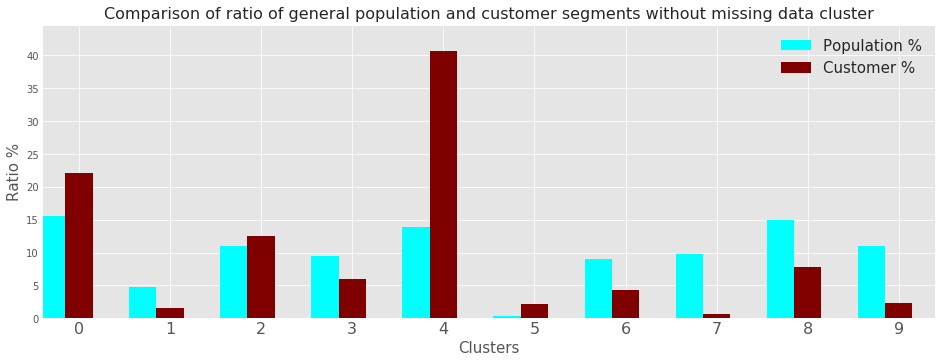

In [433]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# Visualize ratios for each cluster

fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(111)
ax = final_df['pop_%'].plot(x=final_df['cluster'], kind='bar',color='aqua',width=-0.3, align='edge',position=0)
ax = final_df['cust_%'].plot(kind='bar',color='maroon',width = 0.3, align='edge',position=1)
ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=[0,1,2,3,4,5,6,7,8,9,10,11])
ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
plt.xticks(rotation=360,)

plt.legend(('Population %', 'Customer %'),fontsize=15)
plt.title(('Comparison of ratio of general population and customer segments without missing data cluster')
          ,fontsize=16)
plt.subplots_adjust(bottom=0.2)
plt.show()


# Accounting for the missing qualitatively different data for clustering 

In [434]:
# Obtaining missing row data for customer dataset
missingdata_2 = customers.isnull().sum(axis=1)
customer_rows_deleted = customers[customers.index.isin(missingdata_2[missingdata_2 > 5].index)]
customer_rows_deleted[:4]

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,NaN,4.0,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,4.0,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
10,NaN,3.0,2,5.0,4,2,4,4,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,3.0,1,6.0,5,2,4,2,4,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,4.0,5.0,5.0


In [435]:
# Missing rows from population dataset
population_rows_deleted = data_missing_above5.shape[0]
population_rows_deleted

194112

In [436]:
# Missing rows from customer dataset
customer_rows_deleted = customer_rows_deleted.shape[0]
customer_rows_deleted

71610

In [437]:
# Add missing data rows as an extra cluster to dataframe
final_df.loc[-1] = ['-1', population_rows_deleted, customer_rows_deleted,0,0,0]  # adding a row
final_df.index = final_df.index + 1 # shifting index
final_df.sort_index(inplace=True)

In [438]:
# Recalculate ratios and differences
final_df['pop_%'] = (final_df['population']/final_df['population'].sum()*100).round(2)
final_df['cust_%'] = (final_df['customer']/final_df['customer'].sum()*100).round(2)
final_df['diff'] = final_df['cust_%'] - final_df['pop_%']
final_df

,cluster,population,customer,pop_%,cust_%,diff
0,-1,194112,71610,21.78,36.39,14.61
1,0,108397,27636,12.16,14.04,1.88
2,1,33118,1911,3.72,0.97,-2.75
3,2,76253,15747,8.56,8.00,-0.56
4,3,66471,7441,7.46,3.78,-3.68
5,4,97099,50842,10.90,25.84,14.94
6,5,2949,2631,0.33,1.34,1.01
7,6,62814,5326,7.05,2.71,-4.34
8,7,68593,807,7.70,0.41,-7.29
9,8,104255,9838,11.70,5.00,-6.70


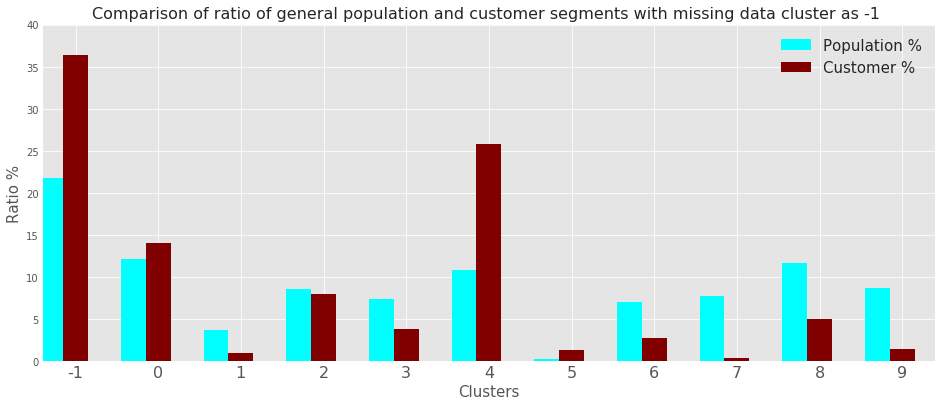

In [440]:
# Revisualizing cluster rations with missing row cluster as -1

fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(111) # Create matplotlib axes
#ax2 = ax.twinx()

ax = final_df['pop_%'].plot(x=final_df['cluster'], kind='bar',color='aqua',width=-0.3, align='edge',position=0)
ax = final_df['cust_%'].plot(kind='bar',color='maroon',width = 0.3, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=[-1,0,1,2,3,4,5,6,7,8,9,10,11])
ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
plt.xticks(rotation=360,)

plt.legend(('Population %', 'Customer %'),fontsize=15)
plt.title(('Comparison of ratio of general population and customer segments with missing data cluster as -1 ')
          ,fontsize=16)

plt.subplots_adjust(bottom=0.1)

plt.show()

In [412]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Analysis of principal components of cluster  with over-representation in customer segment.
cluster_4 = kmeans_10.cluster_centers_[4]
cluster_4 = pd.Series(cluster_4)
cluster_4.index = cluster_4.index +1
cluster_4.sort_values(ascending=False)

4     1.334486
14    0.343587
17    0.335494
3     0.291783
9     0.240770
7     0.180747
12    0.057743
2    -0.029550
5    -0.067349
8    -0.074640
18   -0.128683
10   -0.134490
20   -0.228539
21   -0.240731
6    -0.252682
16   -0.307534
15   -0.341093
19   -0.352058
13   -0.398734
11   -0.564752
1    -1.083976
dtype: float64

In [220]:
# Transforming cluster 4 to original feature values.
cluster_4_features = scaler.inverse_transform(pca_2.inverse_transform(cluster_4))
cluster_4_features = pd.Series(cluster_4_features).round(2)
cluster_4_features.index = header_list
cluster_4_features

ALTERSKATEGORIE_GROB     3.23
ANREDE_KZ                1.47
FINANZ_MINIMALIST        4.46
FINANZ_SPARER            1.93
FINANZ_VORSORGER         3.89
FINANZ_ANLEGER           2.11
FINANZ_UNAUFFAELLIGER    2.36
FINANZ_HAUSBAUER         1.97
GREEN_AVANTGARDE         0.97
HEALTH_TYP               2.12
RETOURTYP_BK_S           3.53
SEMIO_SOZ                4.22
SEMIO_FAM                3.63
SEMIO_REL                3.18
SEMIO_MAT                3.32
SEMIO_VERT               4.77
SEMIO_LUST               5.05
SEMIO_ERL                5.02
SEMIO_KULT               3.71
SEMIO_RAT                3.27
SEMIO_KRIT               4.23
SEMIO_DOM                4.65
SEMIO_KAEM               4.13
SEMIO_PFLICHT            3.34
SEMIO_TRADV              3.19
SOHO_KZ                  0.01
VERS_TYP                 1.48
ANZ_PERSONEN             2.35
ANZ_TITEL                0.00
HH_EINKOMMEN_SCORE       2.24
                         ... 
LP_STATUS_FEIN_9.0       0.07
LP_STATUS_FEIN_10.0      0.77
NATIONALIT

In [442]:
cluster_4_features.GREEN_AVANTGARDE

0.96999999999999997

In [224]:
cluster_4_features.BALLRAUM

4.1100000000000003

In [222]:
# Analyze top principal component in cluster 4
show_pca_weights(4,5)

Principal Component 4
------------------------------
AVANTGARDE             0.3220
GREEN_AVANTGARDE       0.3220
LP_STATUS_FEIN_10.0    0.2455
EWDICHTE               0.2272
ORTSGR_KLS9            0.2268
Name: PC 4, dtype: float64
------------------------------
RURAL                -0.2224
HH_EINKOMMEN_SCORE   -0.2013
BALLRAUM             -0.1847
LP_STATUS_FEIN_4.0   -0.1780
INNENSTADT           -0.1775
Name: PC 4, dtype: float64


In [223]:
show_pca_weights(14,5)

Principal Component 14
------------------------------
ANZ_TITEL               0.3470
LP_STATUS_FEIN_7.0      0.3262
NATIONALITAET_KZ_2.0    0.2366
SHOPPER_TYP_1.0         0.2034
BALLRAUM                0.1495
Name: PC 14, dtype: float64
------------------------------
NATIONALITAET_KZ_1.0   -0.2717
CAMEO_LIFESTAGE        -0.1758
FINANZTYP_5            -0.1611
CAMEO_DEUG_2015_3      -0.1523
LP_STATUS_FEIN_3.0     -0.1466
Name: PC 14, dtype: float64


In [413]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_7 = kmeans_10.cluster_centers_[7]
cluster_7 = pd.Series(cluster_7)
cluster_7.index = cluster_7.index +1
cluster_7.sort_values(ascending=False)

1     1.189239
7     0.624538
13    0.319720
9     0.189324
6     0.171671
18    0.171041
15    0.108773
4    -0.023840
12   -0.096738
19   -0.155515
10   -0.157020
14   -0.178556
21   -0.236562
5    -0.302766
20   -0.369225
3    -0.465837
11   -0.476309
16   -0.485634
17   -0.506593
2    -0.786990
8    -0.795268
dtype: float64

In [414]:
# Transform cluster 7 to original feature values.
cluster_7_features = scaler.inverse_transform(pca_2.inverse_transform(cluster_7))
cluster_7_features = pd.Series(cluster_7_features).round(2)
cluster_7_features.index = header_list
cluster_7_features

ALTERSKATEGORIE_GROB     1.60
ANREDE_KZ                1.69
FINANZ_MINIMALIST        1.20
FINANZ_SPARER            4.65
FINANZ_VORSORGER         1.99
FINANZ_ANLEGER           4.50
FINANZ_UNAUFFAELLIGER    3.97
FINANZ_HAUSBAUER         4.25
GREEN_AVANTGARDE         0.07
HEALTH_TYP               2.19
RETOURTYP_BK_S           2.08
SEMIO_SOZ                4.27
SEMIO_FAM                4.66
SEMIO_REL                5.57
SEMIO_MAT                4.53
SEMIO_VERT               3.44
SEMIO_LUST               2.69
SEMIO_ERL                3.36
SEMIO_KULT               4.92
SEMIO_RAT                5.45
SEMIO_KRIT               4.37
SEMIO_DOM                4.91
SEMIO_KAEM               4.77
SEMIO_PFLICHT            5.91
SEMIO_TRADV              5.41
SOHO_KZ                  0.00
VERS_TYP                 1.51
ANZ_PERSONEN             1.37
ANZ_TITEL                0.00
HH_EINKOMMEN_SCORE       5.42
                         ... 
LP_STATUS_FEIN_9.0       0.02
LP_STATUS_FEIN_10.0     -0.01
NATIONALIT

In [415]:
# Analyze top principal component in cluster 7
show_pca_weights(1,5)

Principal Component 1
------------------------------
PLZ8_ANTG3            0.1895
HH_EINKOMMEN_SCORE    0.1833
PLZ8_ANTG4            0.1828
ORTSGR_KLS9           0.1677
EWDICHTE              0.1641
Name: PC 1, dtype: float64
------------------------------
MOBI_REGIO          -0.2092
FINANZ_MINIMALIST   -0.2036
KBA05_ANTG1         -0.1953
PLZ8_ANTG1          -0.1888
KBA05_GBZ           -0.1861
Name: PC 1, dtype: float64


In [416]:
# Analyze top principal component in cluster 7
show_pca_weights(7,5)

Principal Component 7
------------------------------
OST_WEST_KZ             0.2768
FINANZ_HAUSBAUER        0.1903
NATIONALITAET_KZ_1.0    0.1695
SHOPPER_TYP_3.0         0.1681
LP_STATUS_FEIN_2.0      0.1599
Name: PC 7, dtype: float64
------------------------------
KBA13_ANZAHL_PKW       -0.2888
PLZ8_HHZ               -0.2827
PLZ8_GBZ               -0.2707
HEALTH_TYP             -0.2011
NATIONALITAET_KZ_2.0   -0.1744
Name: PC 7, dtype: float64


In [229]:
cluster_7_features.OST_WEST_KZ

0.33000000000000002

In [230]:
cluster_7_features.KBA13_ANZAHL_PKW

575.50999999999999

In [231]:
cluster_7_features.HEALTH_TYP

2.1899999999999999

In [232]:
cluster_7_features.FINANZ_HAUSBAUER

4.25

# Analyzing the affect of missing data cluster -1 for a probable target audience 

In [418]:
cluster_10 = kmeans_10.cluster_centers_[-1]
cluster_10 = pd.Series(cluster_10)
cluster_10.index = cluster_10.index +1
cluster_10.sort_values(ascending=False)

10    1.287748
12    1.102999
14    0.893839
1     0.725448
11    0.373182
8     0.323891
20    0.182819
5     0.067471
16    0.067234
15    0.056010
6     0.037417
3     0.036197
21    0.031668
17    0.012091
4    -0.010425
19   -0.056048
18   -0.189963
9    -0.286774
2    -0.446481
7    -0.755944
13   -0.779218
dtype: float64

In [419]:
# Transform missing data cluster to original feature values.
cluster_10_features = scaler.inverse_transform(pca_2.inverse_transform(cluster_10))
cluster_10_features = pd.Series(cluster_10_features).round(2)
cluster_10_features.index = header_list
cluster_10_features

ALTERSKATEGORIE_GROB     1.99
ANREDE_KZ                1.49
FINANZ_MINIMALIST        2.40
FINANZ_SPARER            3.38
FINANZ_VORSORGER         3.03
FINANZ_ANLEGER           3.15
FINANZ_UNAUFFAELLIGER    3.01
FINANZ_HAUSBAUER         3.45
GREEN_AVANTGARDE         0.13
HEALTH_TYP               2.51
RETOURTYP_BK_S           3.32
SEMIO_SOZ                4.69
SEMIO_FAM                4.99
SEMIO_REL                5.33
SEMIO_MAT                4.65
SEMIO_VERT               4.07
SEMIO_LUST               3.22
SEMIO_ERL                3.69
SEMIO_KULT               5.22
SEMIO_RAT                4.86
SEMIO_KRIT               4.56
SEMIO_DOM                4.75
SEMIO_KAEM               4.29
SEMIO_PFLICHT            5.65
SEMIO_TRADV              4.88
SOHO_KZ                  0.01
VERS_TYP                 1.64
ANZ_PERSONEN             1.91
ANZ_TITEL               -0.00
HH_EINKOMMEN_SCORE       5.30
                         ... 
LP_STATUS_FEIN_9.0       0.04
LP_STATUS_FEIN_10.0      0.08
NATIONALIT

In [421]:
show_pca_weights(10,5)

Principal Component 10
------------------------------
NATIONALITAET_KZ_2.0    0.2583
NATIONALITAET_KZ_3.0    0.2246
FINANZTYP_2             0.1946
SEMIO_RAT               0.1799
FINANZ_VORSORGER        0.1684
Name: PC 10, dtype: float64
------------------------------
NATIONALITAET_KZ_1.0   -0.3642
CJT_GESAMTTYP_4.0      -0.2172
FINANZTYP_6            -0.1847
PLZ8_HHZ               -0.1405
DECADE                 -0.1401
Name: PC 10, dtype: float64


In [422]:
show_pca_weights(12,5)

Principal Component 12
------------------------------
NATIONALITAET_KZ_2.0    0.2385
ZABEOTYP_4              0.2305
VERS_TYP                0.2246
CAMEO_LIFESTAGE         0.2178
NATIONALITAET_KZ_3.0    0.2153
Name: PC 12, dtype: float64
------------------------------
NATIONALITAET_KZ_1.0   -0.3302
SEMIO_MAT              -0.2220
LP_STATUS_FEIN_9.0     -0.1514
ZABEOTYP_5             -0.1466
REGIOTYP               -0.1380
Name: PC 12, dtype: float64


In [467]:
cluster_10_features.PLZ8_HHZ

3.6800000000000002

In [469]:
cluster_10_features.VERS_TYP

1.6399999999999999

In [466]:
cluster_7_features.KBA05_GBZ

2.5099999999999998

### Discussion 3.3: Compare Customer Data to Demographics Data

**Statistics of both the population and customer clusters without the missing data cluster**

From the first plot in this, it was found that the customer dataset is over-represented in clusters 4 and 0 at around 26% and 6 % difference respectively compared with the general population. Similarly customer dataset is under-represented in clusters 1, 3, 6, 7, 8 and 9 at 3-10% of difference compared with the general population.

**Popular Customer Segments**

The cluster 4 showed significant amount of over-representation (approx. 26%) pertaining to the Bertelsmann Arvato Analytics core customer base. The principal components 4 and 14 were the strongest associations with cluster 4.

The top 5 positive weights for component 4 and their original feature values were as follows:

1. "AVANTGARDE", feature value = 0.97,  unorthodox individuals
2. "GREEN_AVANTGARDE", feature value = 0.97,  individuals with high green environment values
3. "LP_STATUS_FEIN_10.0", feature value = 0.77, a top earner individual
4. "EWDICHTE", feature value = 3.87,  medium density population area
5. "ORTSGR_KLS9", feature value = 5.28, communities of 20,000-50,000 inhabitants

Top five negative weights for component 4 and their original feature value were as follows:

1. "RURAL", feature value = 0.14, signifies not in a rural area
2. "HH_EINKOMMEN_SCORE", feature value = 2.24, individuals with as very high income
3. "BALLRAUM", feature score = 4.11, individuals living 30-40km from urban center
4. "LP_STATUS_FEIN_4.0",feature score = -0.02, not villagers
5. "INNENSTADT",feature score = 4.67, individuals staying 5-10 kilometer to a city center

From this we get a picture of customers who are a great target audience for Bertelsmann Arvato Analytics core customer base. These type of individuals are unorthodox, high earning people staying in close proximity to the urban center in medium density population area.

**Unpopular Customer Segments**

The cluster 7 showed maximum amount of under-representation (approx. 9%) pertaining to the company's core customer base. The principal components 1 and 7 were the strongest associations with cluster 7.

The top 5 positive weights for component 1 and their original feature values were as follows:

1. "PLZ8_ANTG3", feature value = 2.25, average share of 6-10 family homes
2. "HH_EINKOMMEN_SCORE", feature value = 5.41, low income to very low income individuals
3. "PLZ8_ANTG4", feature value = 1.11,  lower share of 10+ family homes
4. "ORTSGR_KLS9", feature value = 6.28, communities of 50,000-100,000 inhabitants
5. "EWDICHTE", feature value = 4.62, 999 households per km^2 (high density areas)

The top 5 negative weights for component 1 and their original feature values were as follows:

1. "MOBI_REGIO", feature value = 2.12, high movement individuals
2. "FINANZ_MINIMALIST", feature value = 1.2, very high unknown/low financial interest
3. "KBA05_ANTG1", feature score = 0.66, 1-2 or lower family houses in RR3 microcell
4. "PLZ8_ANTG1", feature score = 1.62, lower share of 1-2 family homes in PLZ8 macro-cell features
5. "KBA05_GBZ", feature score = 2.5, number of buildings in microcell is between 3 and 16

The above analysis gives an idea of the people who are not customers for Bertelsmann Arvato Analytics. They are low to very low income earners who live in relatively high density urban towns and small cities with many buildings filled with crowded communities with 50,000-100,000 inhabitants. They seldom have interest in financial matters and are high movement individuals and families.

**Statistics of both the population and customer clusters with the missing data cluster**

With the introduction of missing row data as a cluster, the equation was same with cluster 4 overrepresenting and cluster 7 underrepresenting as per the company's customer base. However,there was a significant difference present. When I revisualized the comparison in ratio of general population with customers, the missing row data cluster stood out with similar overrepresentation of 14% compared to cluster 4. The missing row data requires more investigation and could be a potential source of information if considered. Theses individuals are not house owners but price driven foreign/German nationals. They  are money savers but have an insurance topology type as individualistic ready to accept risks and might be a probable customer segment to be targeted by the company as a potential source of revenue.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

# CITATION OF SOURCES AND REFERENCES

**K-Means**


- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a
- https://en.wikipedia.org/wiki/K-means_clustering
    
    
**PCA**


- https://mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
- https://stackoverflow.com/questions/12067446/how-many-principal-components-to-take


**Other references**


- https://towardsdatascience.com/unsupervised-learning-and-data-clustering-eeecb78b422a
- https://www.datarobot.com/wiki/unsupervised-machine-learning/
- https://classroom.udacity.com/nanodegrees/nd229/parts/78c059d0-dff0-44ee-b737-2fcd5cef2ccb/modules/2ad2c343-3cf6-4bdd-9e00-5aa6c13325f3/lessons/ed07728e-a81d-4c5f-bd57-82b2f2cae2da/project
- https://github.com/paulstancliffe/Udacity-Arvato-Unsupervised/blob/master/Identify_Customer_Segments.ipynb
- https://github.com/S-Tabor/udacity-customer-segmentation-project/blob/master/identify_customer_segments_final.ipynb
- https://towardsdatascience.com/10-tips-for-choosing-the-optimal-number-of-clusters-277e93d72d92
- https://stats.stackexchange.com/questions/23472/how-to-decide-on-the-correct-number-of-clusters